In [3]:
library(metacell)
library(GEOquery)
library(googlesheets4)
library(googledrive)
library(devtools)
library(reshape2)
library(plyr)
library(dplyr)
library(tibble)
library(ggplot2)
library(tidyverse)
library(tgstat)
library(tgconfig)
library(gridExtra)
library(SingleCellExperiment)
library(babelgene)
library(zellkonverter)
library(liana)
library(ComplexHeatmap)
library(grid)
library(GOfuncR)
library(cowplot)
library(R.utils)
library(Hmisc)
library(corrplot)
library(pheatmap)
library(shades)


Attaching package: ‘babelgene’


The following object is masked from ‘package:GenomeInfoDb’:

    species


The following object is masked from ‘package:BiocGenerics’:

    species


Loading required package: grid

ComplexHeatmap version 2.13.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: vioplot

Loading required package: sm

Package 'sm', version

In [4]:
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/metacell_functions.r")
source_url("https://raw.githubusercontent.com/aygoldberg/PIC-seq/master/scripts/pic_parser.r")

ℹ SHA-1 hash of file is "bda7f06ee7b168c0be4c723ee15644ab99e6421e"
Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: RANN

Loading required package: plotrix

Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:plotrix’:

    plotCI


The following object is masked from ‘package:shades’:

    space


The following object is masked from ‘package:IRanges’:

    space


The following object is masked from ‘package:S4Vectors’:

    space


The following object is masked from ‘package:stats’:

    lowess


Loading required package: parallel

Loading required package: compositions

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:IRanges’:

    cor, cov, var


The following objects are masked from ‘package:S4Vectors’:

    cor, c

In [5]:
if(!dir.exists("scdb")) dir.create("scdb/")
scdb_init("scdb/", force_reinit=T)
#> initializing scdb to testdb/

initializing scdb to scdb/



In [6]:
if(!dir.exists("final_figs")) dir.create("final_figs/")
scfigs_init("final_figs/")

In [7]:
annot_df <- read.csv("annotations/kinetics_annots.csv", sep=",")
annot_df$label = trimws(annot_df$label)

In [ ]:
mcell_mc_add_annot("kinetics_mc", annot_df$label)
mcell_mc_add_color("kinetics_mc", annot_df$color)

In [8]:
mat = scdb_mat("kinetics_singlets")
mc = scdb_mc("kinetics_mc")

In [9]:
which(mc@annots == 'Neutrophils')

[1] 626 627 628

In [10]:
bad_genes = as.character(read_lines('annotations/kinetics_filtered_genes.txt'))
rp_markers = grep("Rpl|Rps|Snor|Gm|Ig[h,k,l]v|^mt-|Hist|Hsp|Jun|Rik", colnames(mat@mat), v=T)

In [11]:
FACS_filters = c("CD45+", "CD45-", "EPCAM")
ages = age_order = c("10d", "3w", "6w", "8w", "10w", "12w")
conditions = cond_order = c("tumor", "normal")
age_condition_order = paste(rep(rev(cond_order), each=6), rep(age_order, 2), sep="_")

In [12]:
for (i in 1:length(unique(annot_df$label))){
    message(paste(i, unique(annot_df$label)[i], sep=": "))
}

1: Endothelial

2: doublets

3: Mcam Endothelial

4: Dpp4 fibroblasts

5: IFN Dpp4 fibroblasts

6: fibroblasts

7: CAFs

8: Pre-adipocytes

9: Schwann cells

10: Smooth muscle

11: Pericytes

12: Alveolar spp l

13: Progenitor 1

14: Alveolar

15: Alveolar secretory

16: Alveolar spp1 h

17: Progenitor 2

18: HS

19: Basal

20: Hair-like

21: MyoLum

22: Myoepithelial

23: Mast cells

24: Cytotoxic NK

25: NK cells

26: gd NKT Ccl5 l

27: NKT cells

28: gd NKT Ccl5 h

29: Mreg DCs

30: Basophils

31: B cells

32: T cells

33: CD8 T cells

34: Treg

35: gd T cells

36: ILC2

37: Perivasc macs

38: Neutrophils

39: Monocytes

40: MonMacs

41: cDC2

42: Ductal macs

43: pDC

44: cDC1



In [13]:
cat(c(32, 33, 34, 35, 36, 37, 27, 28, 26, 25, 24, 38, 31) - 1, sep=', ')

31, 32, 33, 34, 35, 36, 26, 27, 25, 24, 23, 37, 30

In [14]:
doublet_order = c(2, 20)
doublet_clusters = unique(annot_df$label)[doublet_order]
lymphoid_order = c(32, 33, 34, 35, 26, 28, 27, 25, 24, 36, 31)
myeloid_order = c(39, 40, 37, 42, 44, 41, 43, 29, 23, 30, 38)
epithelial_order = c(13, 17, 14, 18, 22, 19, 21, 12, 16, 15)
stromal_order = c(1, 3, 10, 11, 9)
fibroblast_order = c(6, 4, 5, 7, 8)

In [15]:
pop_orders = list(lymphoid=unique(annot_df$label)[lymphoid_order],
                  myeloid=unique(annot_df$label)[myeloid_order],
                  epithelial=unique(annot_df$label)[epithelial_order],
                  stromal=unique(annot_df$label)[stromal_order],
                  fibroblast=unique(annot_df$label)[fibroblast_order])

In [16]:
pop_orders$epithelial

[1] "Progenitor 1"       "Progenitor 2"       "Alveolar"          
 [4] "HS"                 "Myoepithelial"      "Basal"             
 [7] "MyoLum"             "Alveolar spp l"     "Alveolar spp1 h"   
[10] "Alveolar secretory"

In [17]:
cell_type_annots = list(unique(annot_df$label)[c(lymphoid_order, myeloid_order)], 
                        unique(annot_df$label)[c(stromal_order, fibroblast_order)],
                        unique(annot_df$label)[epithelial_order])
names(cell_type_annots) = FACS_filters

In [18]:
order_index = c(lymphoid_order, myeloid_order, epithelial_order, stromal_order, fibroblast_order)
cell_order = unique(annot_df$label)[order_index]

In [19]:
unique(annot_df$label)[!unique(annot_df$label) %in% cell_order]

[1] "doublets"  "Hair-like"

In [20]:
cell_order

[1] "T cells"              "CD8 T cells"          "Treg"                
 [4] "gd T cells"           "gd NKT Ccl5 l"        "gd NKT Ccl5 h"       
 [7] "NKT cells"            "NK cells"             "Cytotoxic NK"        
[10] "ILC2"                 "B cells"              "Monocytes"           
[13] "MonMacs"              "Perivasc macs"        "Ductal macs"         
[16] "cDC1"                 "cDC2"                 "pDC"                 
[19] "Mreg DCs"             "Mast cells"           "Basophils"           
[22] "Neutrophils"          "Progenitor 1"         "Progenitor 2"        
[25] "Alveolar"             "HS"                   "Myoepithelial"       
[28] "Basal"                "MyoLum"               "Alveolar spp l"      
[31] "Alveolar spp1 h"      "Alveolar secretory"   "Endothelial"         
[34] "Mcam Endothelial"     "Smooth muscle"        "Pericytes"           
[37] "Schwann cells"        "fibroblasts"          "Dpp4 fibroblasts"    
[40] "IFN Dpp4 fibroblasts" "CAFs"                 "Pre-adipocytes"

In [131]:
length(mc@mc[mc@annots[mc@mc] %in% cell_order])

[1] 38206

In [132]:
length(mc@mc[mc@annots[mc@mc] %in% cell_order] %>% unique)

[1] 683

In [133]:
table(mat@cell_metadata[mc@annots[mc@mc[mat@cells]] %in% cell_order, c('Age')])[age_order]


 10d   3w   6w   8w  10w  12w 
6179 9105 5413 5160 7191 5158 

In [134]:
table(mat@cell_metadata[mc@annots[mc@mc[mat@cells]] %in% cell_order, c('condition')])


normal  tumor 
 17378  20828 

In [135]:
table(mat@cell_metadata[mc@annots[mc@mc[mat@cells]] %in% cell_order, c('Cell_type')])


CD45+ CD45- EPCAM 
16778 12783  8645 

In [136]:
table(mat@cell_metadata[mc@annots[mc@mc[mat@cells]] %in% cell_order, c('Age','condition')])[age_order,]

     condition
Age   normal tumor
  10d   2674  3505
  3w    4149  4956
  6w    3120  2293
  8w    2452  2708
  10w   2855  4336
  12w   2128  3030

In [139]:
table(mat@cell_metadata[mc@annots[mc@mc[mat@cells]] %in% cell_order, c('Cell_type','condition')])

         condition
Cell_type normal tumor
    CD45+   6948  9830
    CD45-   6452  6331
    EPCAM   3978  4667

In [137]:
table(mat@cell_metadata[mc@annots[mc@mc[mat@cells]] %in% cell_order, c('Age','Cell_type')])[age_order,]

     Cell_type
Age   CD45+ CD45- EPCAM
  10d  2778  1942  1459
  3w   3456  3196  2453
  6w   2072  2110  1231
  8w   2562  1927   671
  10w  3451  2532  1208
  12w  2459  1076  1623

In [27]:
group.colors = annot_df$color[match(cell_order, annot_df$label)]
names(group.colors) = cell_order

In [28]:
good_cellnames = names(mc@mc[mc@annots[mc@mc] %in% cell_order])

In [29]:
full_df = cbind(subset(mat@cell_metadata[good_cellnames,], select=-metacell), 
                metacell=mc@mc[good_cellnames], 
                annotation=mc@annots[mc@mc[good_cellnames]])

In [26]:
full_df[full_df$condition == 'normal' & full_df$Age == '12w' & full_df$annotation %in% pop_orders$epithelial,]

,Amp.Batch.ID,Well_position,Seq.Batch.ID,Date of sequencing,Batch.Set.ID,Owner,Date of sort,"Plate ID (15 characters, no _/+)",Plate description,Empty_well,⋯,pre_cell_deviant_votes,cell_deviant_votes,pre_dissolved,dissolved,pre_metacell,outlier,amp_batch_id,metacell,annotation,replicate
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,⋯,<int>,<int>,<lgl>,<lgl>,<int>,<lgl>,<dbl>,<dbl>,<chr>,<chr>
AB159_C20,AB159,C20,SB004,22/06/2022,Sandra-12w-1,Sandra,19/05/2022,W12-N16-CD45-,week12-1normalplate16CD45-,FALSE,⋯,0,0,FALSE,FALSE,279,FALSE,1,467,Myoepithelial,1
AB159_I2,AB159,I2,SB004,22/06/2022,Sandra-12w-1,Sandra,19/05/2022,W12-N16-CD45-,week12-1normalplate16CD45-,FALSE,⋯,0,0,FALSE,FALSE,129,FALSE,1,494,Myoepithelial,1
AB159_K10,AB159,K10,SB004,22/06/2022,Sandra-12w-1,Sandra,19/05/2022,W12-N16-CD45-,week12-1normalplate16CD45-,FALSE,⋯,0,0,FALSE,FALSE,120,FALSE,1,384,Alveolar,1
AB159_D16,AB159,D16,SB004,22/06/2022,Sandra-12w-1,Sandra,19/05/2022,W12-N16-CD45-,week12-1normalplate16CD45-,FALSE,⋯,0,0,FALSE,FALSE,341,FALSE,1,493,Myoepithelial,1
AB159_O19,AB159,O19,SB004,22/06/2022,Sandra-12w-1,Sandra,19/05/2022,W12-N16-CD45-,week12-1normalplate16CD45-,FALSE,⋯,0,0,FALSE,FALSE,31,FALSE,1,406,HS,1
AB159_H23,AB159,H23,SB004,22/06/2022,Sandra-12w-1,Sandra,19/05/2022,W12-N16-CD45-,week12-1normalplate16CD45-,FALSE,⋯,0,0,FALSE,FALSE,674,FALSE,1,201,Alveolar spp l,1
AB159_O21,AB159,O21,SB004,22/06/2022,Sandra-12w-1,Sandra,19/05/2022,W12-N16-CD45-,week12-1normalplate16CD45-,FALSE,⋯,0,0,FALSE,FALSE,749,FALSE,1,410,HS,1
AB159_N22,AB159,N22,SB004,22/06/2022,Sandra-12w-1,Sandra,19/05/2022,W12-N16-CD45-,week12-1normalplate16CD45-,FALSE,⋯,0,0,FALSE,FALSE,380,FALSE,1,496,Myoepithelial,1
AB159_G23,AB159,G23,SB004,22/06/2022,Sandra-12w-1,Sandra,19/05/2022,W12-N16-CD45-,week12-1normalplate16CD45-,FALSE,⋯,0,0,FALSE,FALSE,439,FALSE,1,384,Alveolar,1


In [30]:
replicate_df = full_df %>%
    group_by(annotation, Age, condition, Cell_type, Replicate) %>% 
    summarise(Count=length(annotation)) %>% drop_na() %>% as.data.frame %>%
    tidyr::complete(annotation, Age, condition, Cell_type, Replicate, fill=list(Count=0))

replicate_df = replicate_df[apply(replicate_df, 1, 
                                  function(x) {x['annotation'] %in% unlist(cell_type_annots[x['Cell_type']])}),] %>%
    group_by(Age, condition, Cell_type, Replicate) %>% 
    summarise(Cell_type=Cell_type, 
              annotation=annotation, 
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count),
              Replicate = Replicate) %>% 
    filter(total != 0)

replicate_df$annotation = factor(replicate_df$annotation, levels=cell_order)
replicate_df$condition = factor(replicate_df$condition, levels=cond_order)
replicate_df$Age = factor(replicate_df$Age, levels=age_order)
replicate_df$Replicate = factor(replicate_df$Replicate, levels=1:5)

`summarise()` has grouped output by 'annotation', 'Age', 'condition',
'Cell_type'. You can override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'Cell_type',
'Replicate'. You can override using the `.groups` argument.


##### Attempted to make it by population:

replicate_df = full_df %>%
    mutate(broad_annotation = ifelse(full_df$annotation %in% unique(annot_df$label)[fibroblast_order], "Fibroblast populations",
                              ifelse(full_df$annotation %in% unique(annot_df$label)[myeloid_order], "Myeloid populations",
                              ifelse(full_df$annotation %in% unique(annot_df$label)[lymphoid_order], "Lymphoid populations",
                              ifelse(full_df$annotation %in% unique(annot_df$label)[epithelial_order], "Epithelial populations",
                              "Stromal populations"))))) %>%
    group_by(annotation, Age, condition, broad_annotation, Replicate) %>% 
    summarise(Count=length(annotation)) %>% drop_na() %>% as.data.frame %>%
    tidyr::complete(annotation, Age, condition, broad_annotation, Replicate, fill=list(Count=0))

replicate_df = replicate_df %>%
    group_by(Age, condition, broad_annotation, Replicate) %>% 
    summarise(broad_annotation=broad_annotation, 
              annotation=annotation, 
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count),
              Replicate = Replicate) %>% 
    filter(total > 20)

replicate_df$annotation = factor(replicate_df$annotation, levels=cell_order)
replicate_df$condition = factor(replicate_df$condition, levels=cond_order)
replicate_df$Age = factor(replicate_df$Age, levels=age_order)
replicate_df$Replicate = factor(replicate_df$Replicate, levels=1:6)

In [85]:
anova_df = sapply(cell_order, function(pop){
    aov_res = aov(fraction ~ Age + condition, data = replicate_df[replicate_df$annotation == pop,])
    pval_df = TukeyHSD(aov_res, which = "Age")$Age %>% as.data.frame %>% select('p adj')
    pval_df['Age', 'p adj'] = summary(aov_res)[[1]]['Age',"Pr(>F)"]
    pval_df['condition', 'p adj'] = summary(aov_res)[[1]]['condition',"Pr(>F)"]
    return(as.matrix(pval_df))
}) %>% t %>% as.data.frame

In [86]:
colnames(anova_df) = c("3w-10d", "6w-10d", "8w-10d", "10w-10d", "12w-10d", "6w-3w", "8w-3w", "10w-3w", "12w-3w", "8w-6w", 
                       "10w-6w", "12w-6w", "10w-8w", "12w-8w", "12w-10w", "Age", "condition")

In [87]:
anova_df = anova_df[c("Age", "condition", "3w-10d", "6w-10d", "8w-10d", "10w-10d", "12w-10d", "6w-3w", "8w-3w", "10w-3w", 
                      "12w-3w", "8w-6w", "10w-6w", "12w-6w", "10w-8w", "12w-8w", "12w-10w")]

In [88]:
corr_anova_df = mutate_all(anova_df, function(x){p.adjust(x, method='fdr')})

In [31]:
facs_data = read_csv("/home/orimosko/projects/updated_breast/kinetic percentages.csv")

New names:
• `` -> `...2`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`
Rows: 161 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): date, ...2, Age, Condition, FACs Filter, Comments, ...8
dbl (3): Percentage, ...9, ...10
lgl (5): ...11, ...12, ...13, ...14, ...15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [237]:
mfi_data = read_csv("MFI.csv")

Rows: 18 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): FACS.gate, Date, Age
dbl (1): MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [138]:
facs_data

date,...2,Age,Condition,FACs Filter,Percentage,Comments,...8,...9,...10,...11,...12,...13,...14,...15
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
16/01/2022,Sandra-10d-1,10d,Normal,CD45,30.50,"12 mg 6 mice, gentle macs",NA,NA,NA,NA,NA,NA,NA,NA
29/06/2022,Sandra-10d-2,10d,Normal,CD45,35.50,CD49f filter,NA,NA,NA,NA,NA,NA,NA,NA
27/11/2022,Sandra-10d-3,10d,Normal,CD45,44.50,NA,NA,NA,NA,NA,NA,NA,NA,NA
16/01/2022,Sandra-10d-1,10d,Normal,EPCAM,4.24,NA,NA,NA,NA,NA,NA,NA,NA,NA
27/11/2022,Sandra-10d-3,10d,Normal,EPCAM,0.87,NA,NA,NA,NA,NA,NA,NA,NA,NA
16/01/2022,Sandra-10d-1,10d,Normal,CD45/EPCAM,0.23,NA,NA,NA,NA,NA,NA,NA,NA,NA
27/11/2022,Sandra-10d-3,10d,Normal,CD45/EPCAM,1.11,NA,NA,NA,NA,NA,NA,NA,NA,NA
27/11/2022,Sandra-10d-3,10d,Normal,LY6G/EPCAM,3.25,FROM PICS GATE,NA,NA,NA,NA,NA,NA,NA,NA
27/11/2022,Sandra-10d-3,10d,Normal,LY6G,2.60,gate from CD45+,NA,NA,NA,NA,NA,NA,NA,NA


In [37]:
facs_data = facs_data[!is.na(facs_data$Percentage),1:7] %>% as.data.frame # CHANGE THIS WHEN RE-RUNNING!

In [38]:
colnames(facs_data) = str_replace(colnames(facs_data), " ", ".")

In [39]:
colnames(facs_data)[2] = 'batch_name'

In [40]:
facs_data = facs_data %>% mutate(Age = factor(Age, levels = age_order), 
                                 Condition = factor(Condition, levels = c('Tumor', 'Normal')))

In [42]:
facs_data[facs_data$FACs.Filter == "LY6G",]

,date,batch_name,Age,Condition,FACs.Filter,Percentage,Comments
,<chr>,<chr>,<fct>,<fct>,<chr>,<dbl>,<chr>
9,27/11/2022,Sandra-10d-3,10d,Normal,LY6G,2.60,gate from CD45+
18,27/11/2022,Sandra-10d-3,10d,Tumor,LY6G,2.87,NA
32,11/09/2022,Sandra-3w-4,3w,Normal,LY6G,1.81,gate from CD45+
47,11/09/2022,Sandra-3w-4,3w,Tumor,LY6G,2.03,from CD45+
74,06/11/2022,Sandra-8w-3,8w,Normal,LY6G,0.60,From CD45
83,06/11/2022,Sandra-8w-3,8w,Tumor,LY6G,2.83,From CD45
95,03/11/2022,Sandra-10w-5,10w,Normal,LY6G,0.71,NA
114,12/09/2022,Sandra-10w-4,10w,Tumor,LY6G,2.54,FROM CD45
115,03/11/2022,Sandra-10w-5,10w,Tumor,LY6G,3.52,FROM CD45


# Figure 1

In [130]:
if(!dir.exists("final_figs/fig1")) dir.create("final_figs/fig1/")

In [131]:
m2d = scdb_mc2d("kinetics_2dproj")

In [132]:
mc_2d = data.frame(x=m2d@sc_x[!mc@annots[mc@mc[names(m2d@sc_x)]] %in% doublet_clusters], 
                   y=m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters], 
                   annotation=mc@annots[mc@mc[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters])]])
mc_2d = mc_2d %>% mutate(annotation=factor(annotation, levels=cell_order))

In [133]:
# B

p = ggplot(mc_2d, aes(x=x, y=y, col=annotation)) +
    geom_point(size=0.5, show.legend = F) +
    geom_bar(aes(y=0, fill=annotation), stat="identity", color="white") +
    scale_color_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    scale_fill_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    theme(axis.title.x = element_blank(), axis.title.y = element_blank(), #legend.text=element_blank(), 
    axis.text.x = element_blank(), axis.text.y = element_blank(),
    axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
    axis.line.x = element_blank(), axis.line.y = element_blank(), )

l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave("final_figs/fig1/2d_visualization.png", plot = p, width = 9, height = 9, dpi = 1200)
ggsave("final_figs/fig1/legend.png", plot=l, dpi = 1200, width = 9)

Warning message:
“Removed 1313 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Saving 9 x 6.67 in image


In [134]:
# B - no letters

p = ggplot(mc_2d, aes(x=x, y=y, col=annotation)) +
    geom_bar(aes(y=0, fill=annotation), stat="identity", color="white") +
    scale_fill_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    theme(axis.title.x = element_blank(), axis.title.y = element_blank(), legend.text=element_blank(), 
    axis.text.x = element_blank(), axis.text.y = element_blank(),
    axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
    axis.line.x = element_blank(), axis.line.y = element_blank(), )

l = get_legend(p)

ggsave("final_figs/fig1/legend_blank.png", plot=l, dpi = 1200, width = 9)

Warning message:
“Removed 1313 rows containing missing values (`position_stack()`).”
Saving 9 x 6.67 in image


In [42]:
# C

df_2d = data.frame(x=m2d@sc_x[!mc@annots[mc@mc[names(m2d@sc_x)]] %in% doublet_clusters], 
                   y=m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters], 
                   color=mc@colors[mc@mc[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters])]],
                   facs=mat@cell_metadata[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters]),
                                                 "Cell_type"],
                   condition=mat@cell_metadata[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters]),
                                                 "condition"])

gbs = apply(expand.grid(conditions, FACS_filters), 1, function(rowrow){
    df_2d = mutate(df_2d, Color=ifelse(condition == rowrow["Var1"] & facs == rowrow["Var2"], 
                                       df_2d$color, 
                                       "#C0C0C0")) 
    ggplot(df_2d %>% arrange(Color), aes(x=x, y=y, color=Color)) +
        geom_point(size=0.01) +
        labs(title = paste(rowrow["Var1"], rowrow["Var2"], sep=" - "), 
             subtitle = paste(sum(df_2d$condition == rowrow["Var1"] & df_2d$facs == rowrow["Var2"], na.rm = T), "cells")) +
        scale_color_identity() +
        theme(plot.title = element_blank(),  
              plot.subtitle = element_blank(),#element_text(size = 10, hjust = 0.5),
              axis.title.x = element_blank(), axis.title.y = element_blank(),
              axis.text.x = element_blank(), axis.text.y = element_blank(),
              axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
              axis.line.x = element_blank(), axis.line.y = element_blank(),
              aspect.ratio=1)
})

 g <- arrangeGrob(grobs=gbs, ncol=2) #generates g
 ggsave(file="final_figs/fig1/facs_conditions_nonumbers.png", g, dpi=1200) #saves g

Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Saving 6.67 x 6.67 in image


In [43]:
df_2d = data.frame(x=m2d@sc_x[!mc@annots[mc@mc[names(m2d@sc_x)]] %in% doublet_clusters], 
                   y=m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters], 
                   color=mc@colors[mc@mc[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters])]],
                   facs=mat@cell_metadata[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters]),
                                                 "Cell_type"],
                   condition=mat@cell_metadata[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters]),
                                                 "condition"])

gbs = apply(expand.grid(conditions, FACS_filters), 1, function(rowrow){
    df_2d = mutate(df_2d, Color=ifelse(condition == rowrow["Var1"] & facs == rowrow["Var2"], 
                                       df_2d$color, 
                                       "#C0C0C0")) 
    ggplot(df_2d %>% arrange(Color), aes(x=x, y=y, color=Color)) +
        geom_point(size=0.01) +
        labs(title = paste(rowrow["Var1"], rowrow["Var2"], sep=" - "), 
             subtitle = paste(sum(df_2d$condition == rowrow["Var1"] & df_2d$facs == rowrow["Var2"], na.rm = T), "cells")) +
        scale_color_identity() +
        theme(plot.title = element_blank(),  
              axis.title.x = element_blank(), axis.title.y = element_blank(),
              axis.text.x = element_blank(), axis.text.y = element_blank(),
              axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
              axis.line.x = element_blank(), axis.line.y = element_blank(),
              aspect.ratio=1)
})

 g <- arrangeGrob(grobs=gbs, ncol=2) #generates g
 ggsave(file="final_figs/fig1/facs_conditions.png", g, dpi=1200) #saves g

Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Saving 6.67 x 6.67 in image


In [105]:
proportion_df = replicate_df %>% 
    group_by(annotation, Age, condition) %>%
    summarise(fraction=mean(fraction)) %>%
    group_by(annotation, condition) %>% 
    summarise(fraction=mean(fraction)) %>%
    as.data.frame %>%
    reshape(idvar = "annotation", timevar = "condition", direction = "wide") %>%
    mutate(log_ratio = log(fraction.tumor / fraction.normal)) %>%
    `rownames<-`(.$annotation)

`summarise()` has grouped output by 'annotation', 'Age'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'annotation'. You can override using the
`.groups` argument.


In [106]:
proportion_df = proportion_df[cell_order,]
proportion_df$color = group.colors[proportion_df$annotation]
proportion_df$annotation = factor(proportion_df$annotation, 
                                  levels=proportion_df$annotation[order(proportion_df$log_ratio)])

In [107]:
proportion_df$annotation

[1] T cells              CD8 T cells          Treg                
 [4] gd T cells           gd NKT Ccl5 l        gd NKT Ccl5 h       
 [7] NKT cells            NK cells             Cytotoxic NK        
[10] ILC2                 B cells              Monocytes           
[13] MonMacs              Perivasc macs        Ductal macs         
[16] cDC1                 cDC2                 pDC                 
[19] Mreg DCs             Mast cells           Basophils           
[22] Neutrophils          Progenitor 1         Progenitor 2        
[25] Alveolar             HS                   Myoepithelial       
[28] Basal                MyoLum               Alveolar spp l      
[31] Alveolar spp1 h      Alveolar secretory   Endothelial         
[34] Mcam Endothelial     Smooth muscle        Pericytes           
[37] Schwann cells        fibroblasts          Dpp4 fibroblasts    
[40] IFN Dpp4 fibroblasts CAFs                 Pre-adipocytes      
42 Levels: Alveolar HS Myoepithelial Progenitor 1 Basal ... Mcam Endothelial

In [108]:
range1 = 1:length(lymphoid_order)
range2 = (max(range1)+1):(max(range1)+length(myeloid_order))
range3 = (max(range2)+1):(max(range2)+length(epithelial_order))
range4 = (max(range3)+1):(max(range3)+length(fibroblast_order))
range5 = (max(range4)+1):(max(range4)+length(stromal_order))

In [109]:
proportion_df$annotation = factor(proportion_df$annotation, 
                                  levels=proportion_df$annotation[c(c(range1)[order(proportion_df[range1,"log_ratio"])],
                                                                    c(range2)[order(proportion_df[range2,"log_ratio"])],
                                                                    c(range3)[order(proportion_df[range3,"log_ratio"])],
                                                                    c(range4)[order(proportion_df[range4,"log_ratio"])],
                                                                    c(range5)[order(proportion_df[range5,"log_ratio"])])
                                                                 ]
                                 )

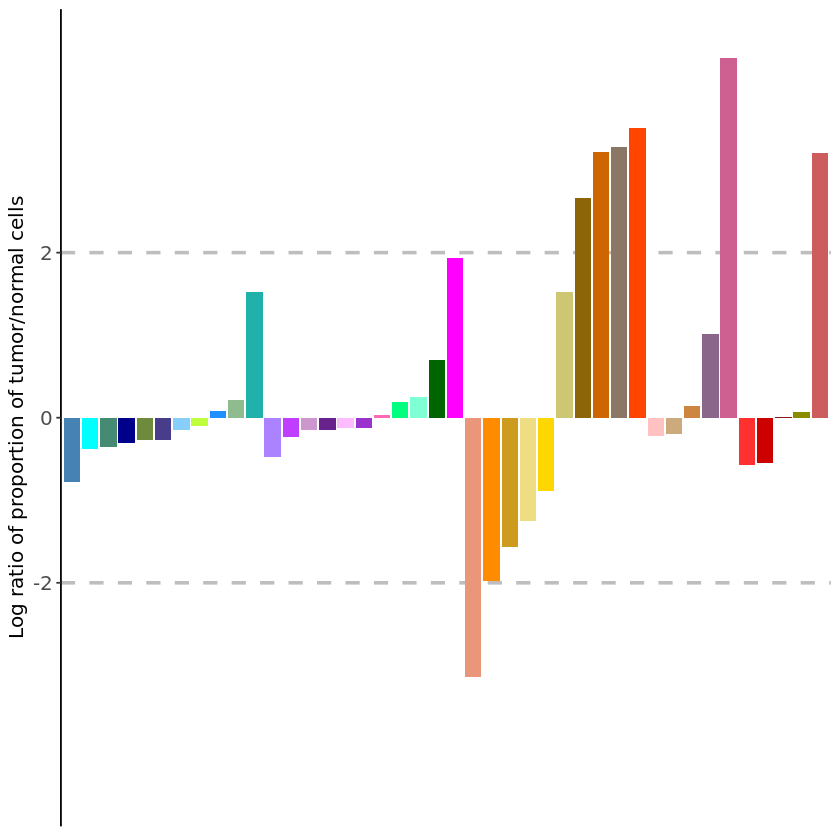

In [110]:
ggplot(proportion_df, aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(-2, 2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2), limits = c(-4.5, 4.5)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_all.png", dpi = 1200,
       width = 8, height = 6)

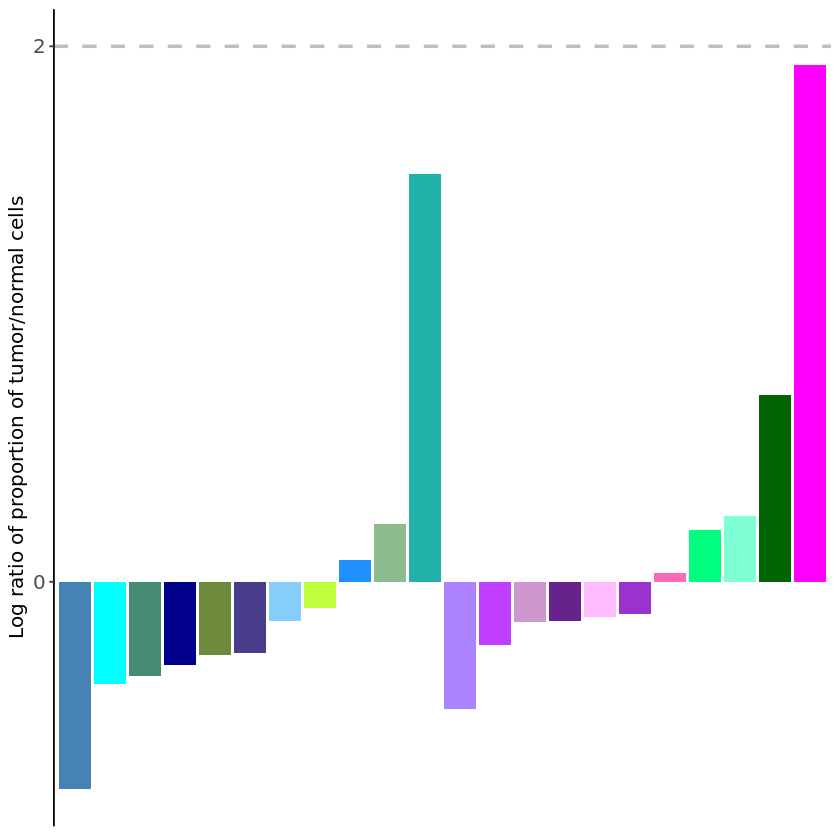

In [111]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[c(range1, range2)],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_cd45.png", dpi = 1200,
       width = 6, height = 6)

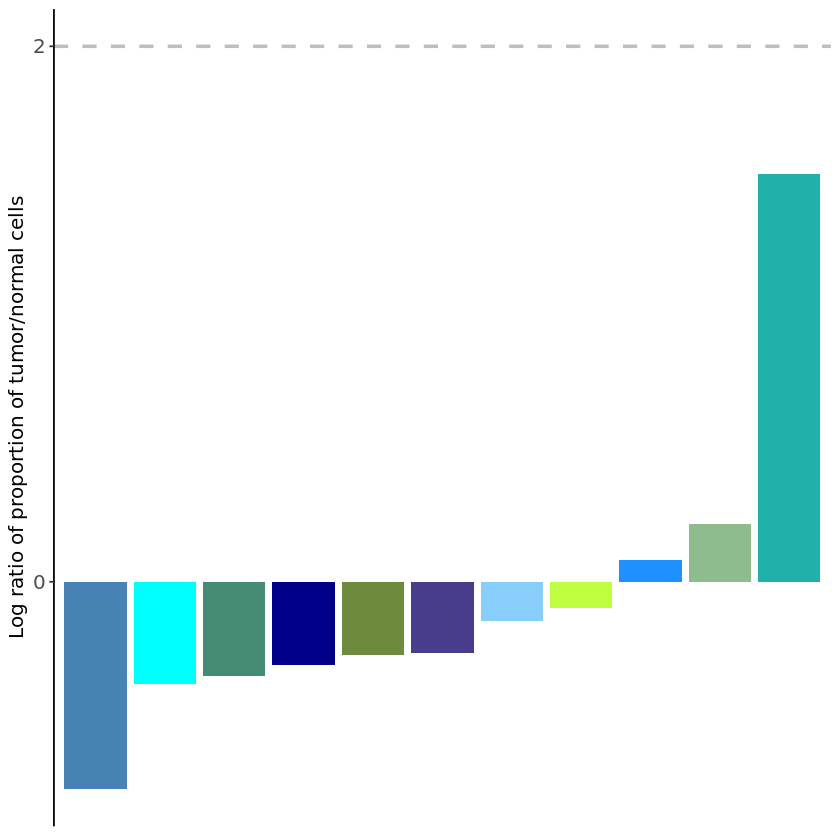

In [112]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range1],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_lymphoid.png", dpi = 1200,
       width = 6, height = 6)

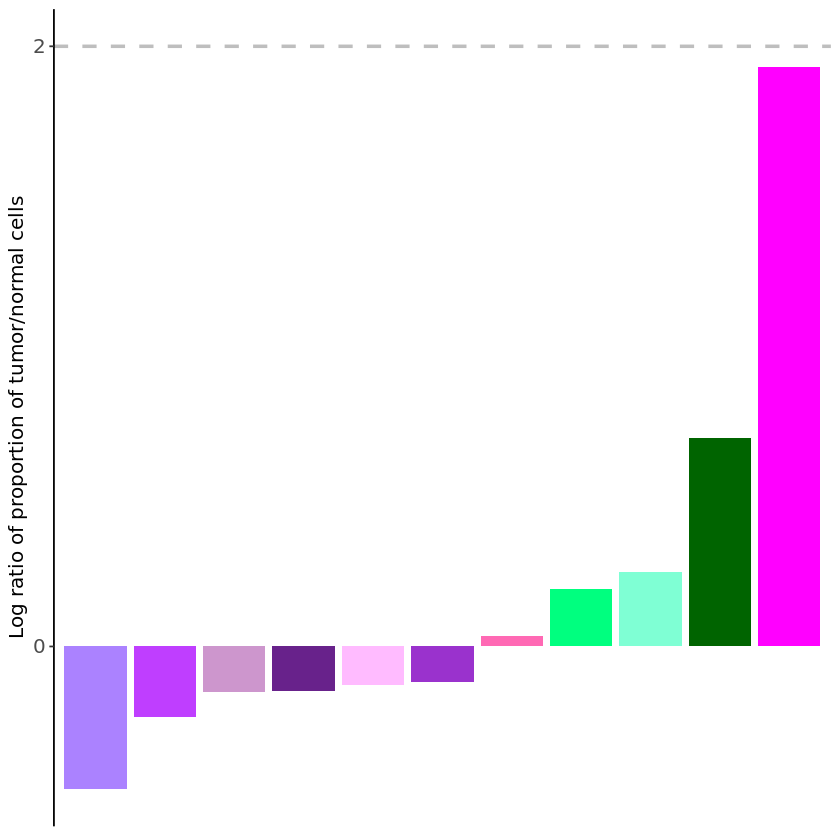

In [113]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range2],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_myeloid.png", dpi = 1200,
       width = 6, height = 6)

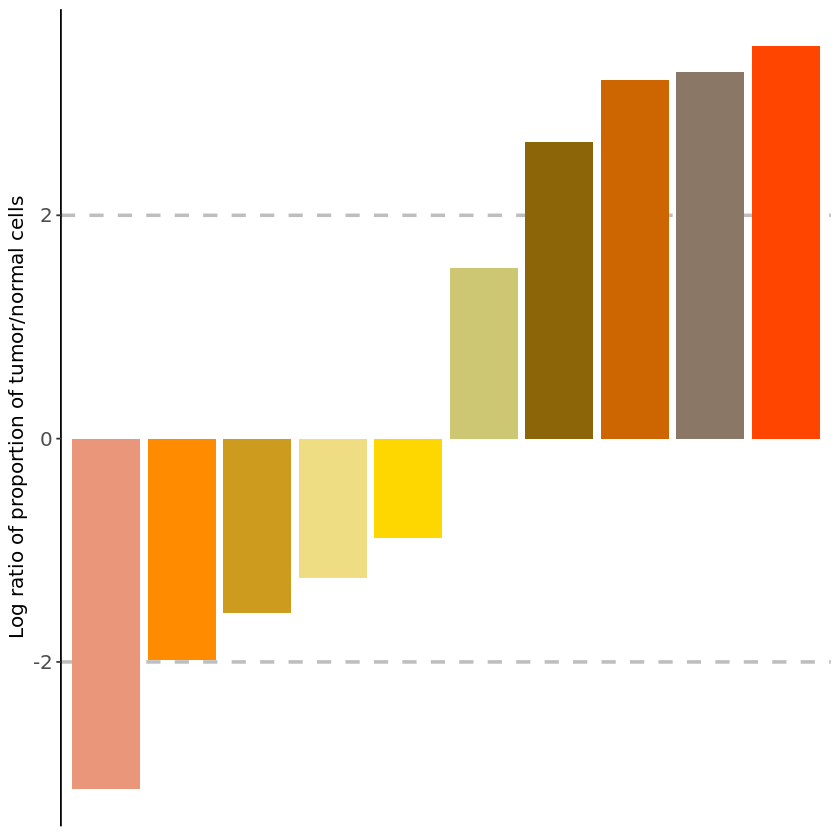

In [114]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range3],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(-2, 2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_epcam.png", dpi = 1200,
       width = 6, height = 6)

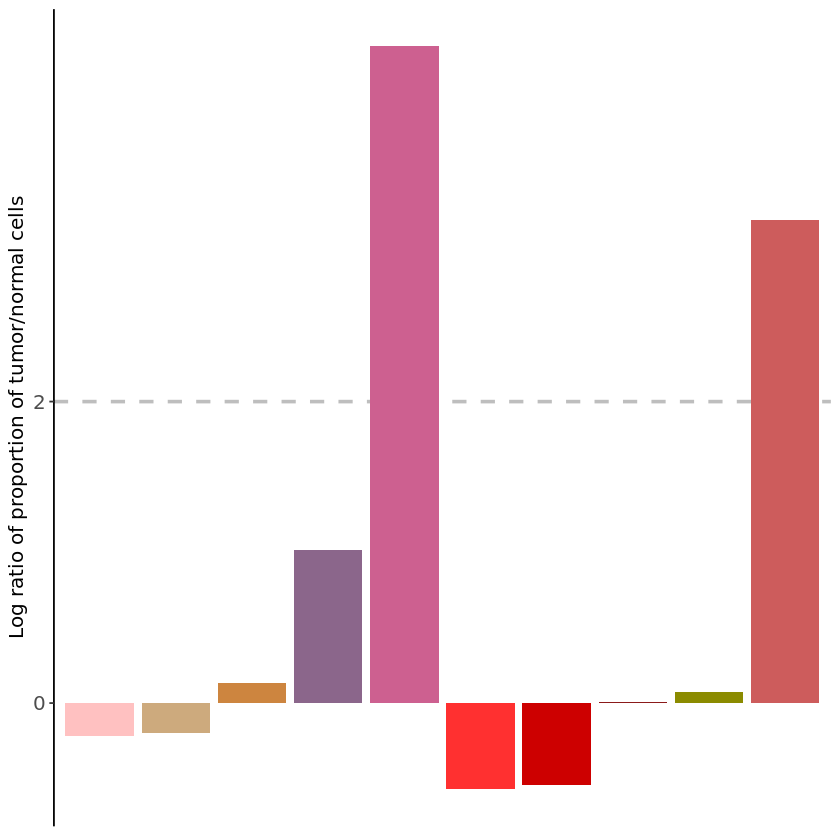

In [115]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[c(range4, range5)],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_cd45-.png", dpi = 1200,
       width = 6, height = 6)

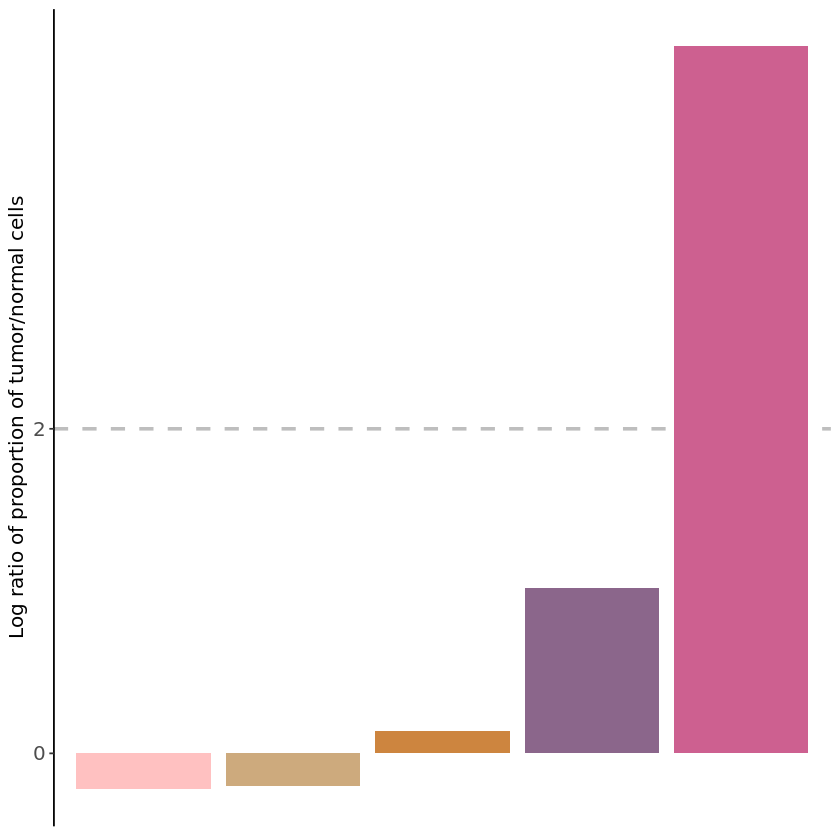

In [116]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range4],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_perivasc.png", dpi = 1200,
       width = 6, height = 6)

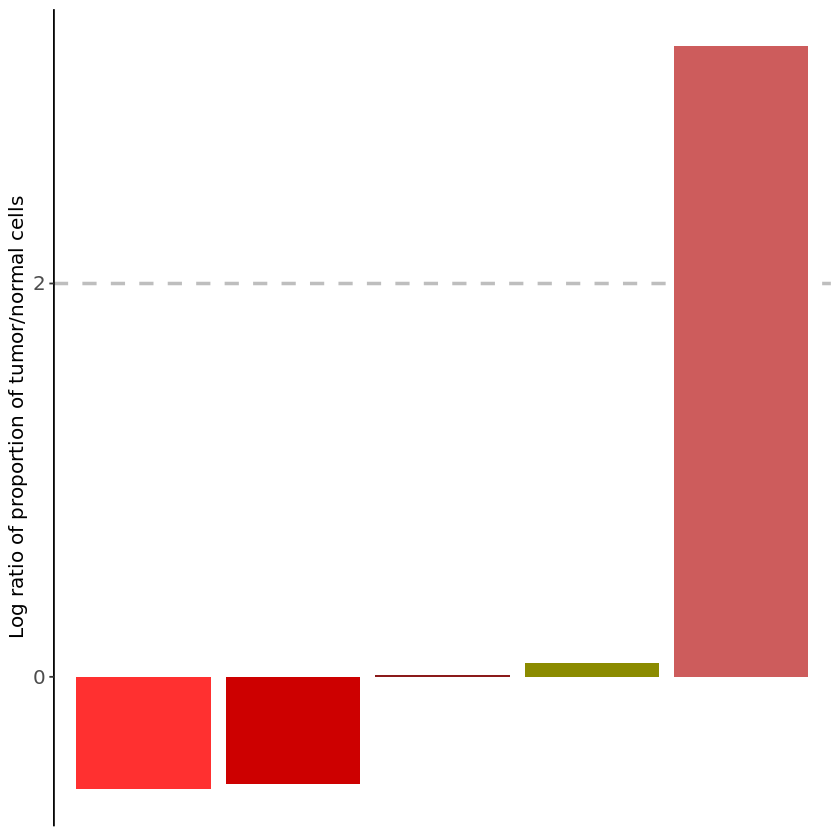

In [117]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range5],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_fibrobalsts.png", dpi = 1200,
       width = 6, height = 6)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“devEMF: your system substituted font family 'DejaVu Sans' when you requested 'Arial'”


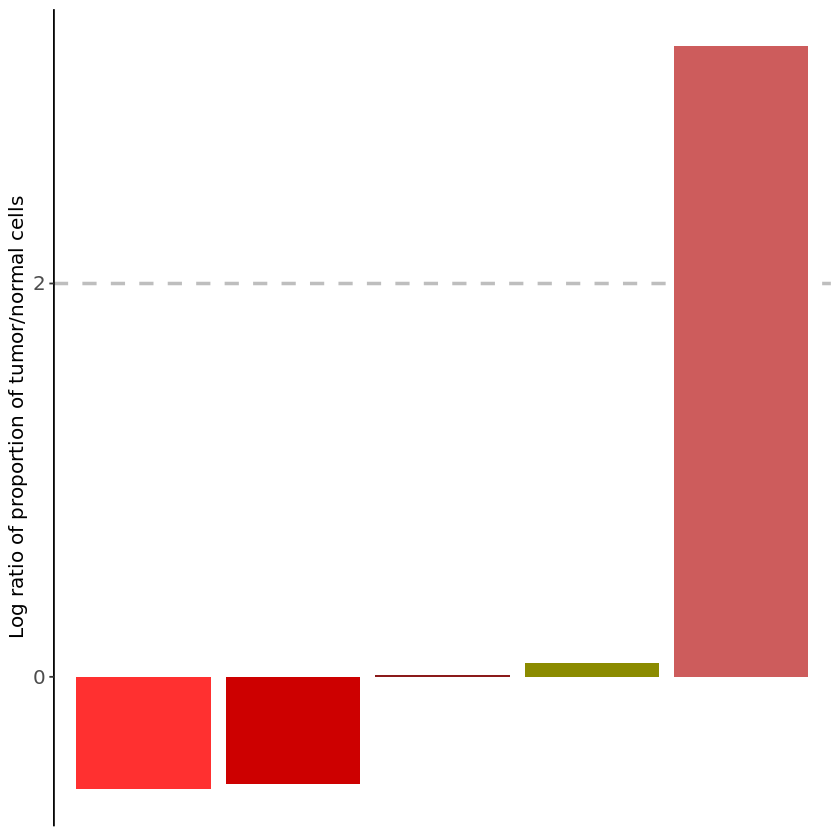

In [123]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range5],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(text = element_text(family = 'Arial'), axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_fibrobalsts.emf", width = 6, height = 6, 
       device = {function(filename, ...) devEMF::emf(file = filename, family = 'Arial')})

In [120]:
install.packages('devEMF')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# Supp figure 1

In [42]:
c_vec = mc@colors[!duplicated(mc@colors)]
names(c_vec) = mc@annots[!duplicated(mc@annots)]

In [278]:
hm_genes = list(
    lymphoid=c('Cd79b', 'Ms4a1', 'Cd19', 'H2-DMb2',
               'Id2', 'S100a4', 'Il7r', 'Cxcr6', 
               'Il1rl1', 'Arg1', 'Csf2', 'Rora', 'Gata3',
               'Gzma', 'Prf1', 'Ncr1', 
               'Klrd1', 'Ccl5', 'Nkg7', 'Gzmb', 
               'Itgae', 'Trgc1', 'Trgc2', 'Trdc',
               'Icos', 'Ctla4', 'Foxp3', 'Cd4',
               'Cd8a', 'Cd8b1', 
               'Trbc2', 'Trbc1', 'Trac', 'Cd3e', 'Tcf7'),
    myeloid=c('Csf3r', 'S100a8', 'S100a9', 'Retnlg',
              'Il6', 'Mcpt8', 'Osm', 'Ccl3', 'Ccl6',
              'Fscn1', 'Epsti1', 'Ccl22', 'Ccl17',
              'Cma1', 'Cpa3', 'Tpsb2', 'Mcpt4',
              'Siglech', 'Cd209d', 'Ccr9', 
              'Clec10a', #'H2-Aa', 'H2-Ab1', 'Cd74',
              'Cd209a', 'Irf8', 'Xcr1',
              'Cx3cr1', 'Spp1', 'Trem2', 'Ms4a7',
              'C1qa', 'Tmem176a', 'Tmem176b', 'Il1b',
              'Csf1r', 'Cd163', 'Cd209f', 
              'Lyve1', 'Mrc1', 'F13a1',
              'Retnla', 'Ccr2', 'Ccl6', 'Lyz1',
              'Lyz2', 'Ear2', 'Plac8'),
    fibroblast=rev(c("Dcn", "Sparc", "Col1a1", "Col3a1", "Ly6a", "Acta2", "Ifitm3", "Anxa3", "Pi16", "Dpp4", "Vegfd", "Cxcl13", 
                     "Irf7", "Ifit3", "C3", "Pla1a", "Cilp", "Cxcl14", "Spon1", "Mgp", "Adipoq", "Aoc3", "Car3")),
    stromal=rev(c("Cav1", "Cdh5", "Pecam1", "Fabp5", "Cd36", "Igfbp7", "Mcam", "Lcn2", "Spp1",
                  #"Csn3", "Lalba", "Krt14", "Epcam",
                  "Tagln", "Myl9", "Myh11", 
                  "Abcc9", "Kcnj8", "Pdgfrb", "Rgs5", 
                  "Sox10", "Mbp", "Cnp", "Plp1", "Mpz", "Pmp22")),
    epithelial=rev(c("Kit", "Cd14", "Aldh1a3", "Mfge8", "Fcgbp", "Wfdc18", "Krt8", "Krt18", "Cp", 
                     "Lalba", "Csn3", 
                     "Cited1", "Pgr", "Esr1", "Prlr", 
                     "Vim", "Col16a1", "Myl9", "Cxcl14", "Acta2", "Pdpn", "Mylk", "Myh11", "Ecrg4", "Oxtr", "Tpm2", 
                     "Krt5", "Krt14", 
                     "Krt17", "Rbp1", "Rflnb", "Gja1", "Pclaf", "Tuba1b", "Hmgb2", "Ccna2",
                     "Spp1",
                     "Wap", "Csn1s1", "Csn1s2a", "Csn2", "Thrsp", "Car6", "Saa1", "Saa2"))
)

In [279]:
for (pop_name in names(hm_genes)){
    focus_genes = unlist(hm_genes[pop_name])
    write_lines(focus_genes, paste0("final_figs/supp1/heatmaps/", pop_name, "_heatmap_genes.txt"))
    focus_mc_nums = which(mc@annots %in% unlist(pop_orders[pop_name]))
    focus_mcs = match(mc@annots[mc@mc[mc@mc %in% focus_mc_nums]], cell_order) * 1000 + mc@mc[mc@mc %in% focus_mc_nums]
    focus_mat = t(mat@mat[,names(focus_mcs[order(focus_mcs, decreasing = F)])])
    focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))    
    heatmap_df = as.matrix(t(focus_mat_norm[,focus_genes]))
    ha = HeatmapAnnotation(Type=factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                       levels = cell_order[cell_order %in% mc@annots[mc@mc[colnames(heatmap_df)]]]), 
                           col = list(Type=c_vec))
    png(file=paste0("final_figs/supp1/heatmaps/", pop_name, ".png"), 
        width     = 10,
        height    = 7,
        units     = "in",
        res       = 1200,
        pointsize = 1
    )

    h = Heatmap(heatmap_df, row_names_gp = gpar(fontsize=10), show_column_dend = F,
                column_split =  factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                       levels = cell_order[cell_order %in% mc@annots[mc@mc[colnames(heatmap_df)]]]),
                heatmap_legend_param = list(labels_gp = gpar(fontsize = 10)),
                cluster_rows = F, cluster_columns =  F, top_annotation = ha, 
                bottom_annotation = ha, show_column_names = F, name="Count",
                col = colorRampPalette(c("white", "orange", "tomato", "mediumorchid4", "midnightblue"))(1000), use_raster = F)
    plot(h)
    dev.off()
}

In [280]:
focus_genes = c(unlist(hm_genes['fibroblast']), unlist(hm_genes['stromal']))
focus_mc_nums = which(mc@annots %in% c(unlist(pop_orders['fibroblast']), unlist(pop_orders['stromal'])))
focus_mcs = match(mc@annots[mc@mc[mc@mc %in% focus_mc_nums]], cell_order) * 1000 + mc@mc[mc@mc %in% focus_mc_nums]
focus_mat = t(mat@mat[,names(focus_mcs[order(focus_mcs, decreasing = F)])])
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))    
heatmap_df = as.matrix(t(focus_mat_norm[,focus_genes]))
ha = HeatmapAnnotation(Type=factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                   levels = cell_order[cell_order %in% mc@annots[mc@mc[colnames(heatmap_df)]]]), 
                       col = list(Type=c_vec))
png(file=paste0("final_figs/supp1/heatmaps/", 'fibro_stromal', ".png"), 
    width     = 10,
    height    = 7,
    units     = "in",
    res       = 1200,
    pointsize = 1
)

h = Heatmap(heatmap_df, row_names_gp = gpar(fontsize=10), show_column_dend = F,
            column_split =  factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                   levels = cell_order[cell_order %in% mc@annots[mc@mc[colnames(heatmap_df)]]]),
            heatmap_legend_param = list(labels_gp = gpar(fontsize = 10)),
            cluster_rows = F, cluster_columns =  F, top_annotation = ha, 
            bottom_annotation = ha, show_column_names = F, name="Count",
            col = colorRampPalette(c("white", "orange", "tomato", "mediumorchid4", "midnightblue"))(1000), use_raster = F)
plot(h)
dev.off()


png 
  2

In [281]:
all_mat = t(mat@mat[,good_cellnames])
lognorm_mat = log1p(10000 * all_mat / rowSums(all_mat))

In [282]:
gene_names = c("Trac", "Gzmb", "Cd79a", "Csf1r", "Csf3r", "Dcn", "Cdh5", "Mpz", "Krt18", "Krt14")

df_2d = data.frame(x=m2d@sc_x[good_cellnames], 
                   y=m2d@sc_y[good_cellnames]) %>% 
    cbind(as.data.frame(as.matrix(lognorm_mat[good_cellnames, gene_names])))

gbs = lapply(gene_names, function(gene_name){

    ggplot(df_2d[order(df_2d[,gene_name], decreasing = F),], aes_string(x='x', y='y', col=gene_name)) +
        geom_point(size=0.1, show.legend = F) +
        scale_color_gradientn(colors=c("ivory2", "orange", "tomato", "mediumorchid4", "midnightblue")) +
        labs(title = gene_name) +
        theme(plot.title = element_blank(),#element_text(size = 8, hjust = 0.5, face = "bold"), 
              axis.title.x = element_blank(), axis.title.y = element_blank(),
              axis.text.x = element_blank(), axis.text.y = element_blank(),
              axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
              axis.line.x = element_blank(), axis.line.y = element_blank(),
              legend.key.size = unit(0.25, 'cm'), legend.text =  element_text(size = 10))

})

In [283]:
 g <- arrangeGrob(grobs=gbs, nrow=5, respect = T) #generates g
 ggsave(file="final_figs/supp1/gene_projections_noname.png", g, dpi = 1200, width = 6, height = 16, units = 'cm') #saves g

Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”


In [284]:
check_if_doublets = function(annot_a, annot_b, annot_c, gene_list, ds_min=500){
    cells_a = names(mc@mc[mc@annots[mc@mc] == annot_a])
    cells_b = names(mc@mc[mc@annots[mc@mc] == annot_b])
    cells_c = names(mc@mc[mc@annots[mc@mc] == annot_c])
    ds_num = max(ds_min, min(length(cells_a), length(cells_b), length(cells_c)))
    gene_list = gene_list[gene_list %in% colnames(lognorm_mat)]
    df_a = lognorm_mat[sample(cells_a, min(ds_num, length(cells_a))),gene_list] %>% t %>% as.matrix %>%
        melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source=annot_a)
    df_b = lognorm_mat[sample(cells_b, min(ds_num, length(cells_b))),gene_list] %>% t %>% as.matrix %>%
        melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source=annot_b)
    df_c = lognorm_mat[sample(cells_c, min(ds_num, length(cells_c))),gene_list] %>% t %>% as.matrix %>%
        melt(varnames = c('gene', 'cell_name'), value.name = 'LogNormExpr') %>% cbind(source=annot_c)
    plot_df = rbind(df_a, df_b, df_c) %>% mutate(gene=factor(gene, levels=gene_list), 
                                                 source=factor(source, levels=c(annot_a, annot_b, annot_c)))
    ggplot(plot_df, aes(x=cell_name, y=gene, fill=LogNormExpr)) +
        geom_tile() +
        scale_fill_gradientn(colors=c("white", "orange", "tomato", "mediumorchid4", "midnightblue")) +
        facet_grid(~ source, scales = 'free_x') +
        theme(axis.text.x = element_blank(), axis.title.x = element_blank(), axis.ticks = element_blank(),
              axis.title.y = element_blank(), axis.text = element_text(size = 12))
}

Saving 6.67 x 6.67 in image


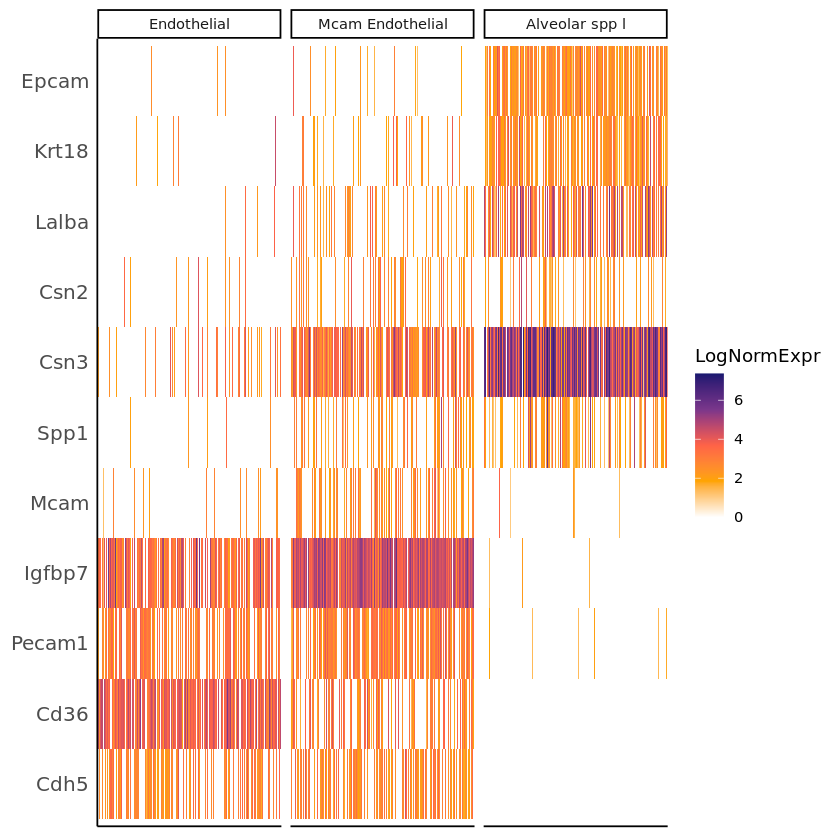

In [285]:
check_if_doublets('Endothelial', 'Mcam Endothelial', 'Alveolar spp l', 
                  c('Cdh5', 'Cd36', 'Pecam1', 'Igfbp7', 'Mcam', 'Spp1', 'Csn3', 'Csn2', 'Lalba', 'Krt18', 'Epcam'))
ggsave('final_figs/supp1/heatmaps/Mcam Endothelial proof.png', dpi=1200)

Saving 6.67 x 6.67 in image


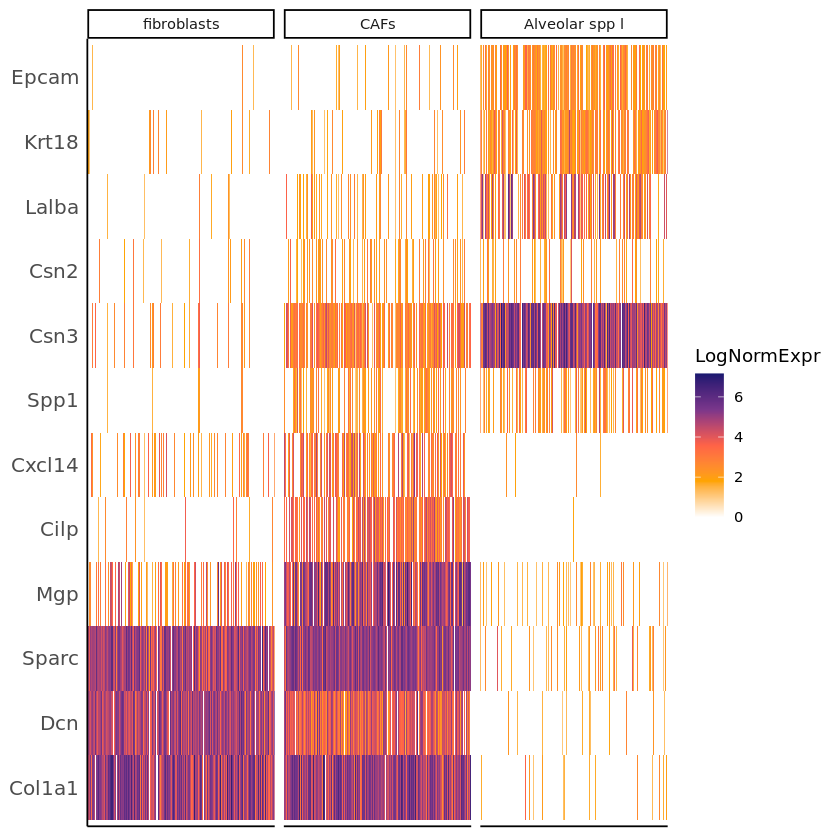

In [286]:
check_if_doublets('fibroblasts', 'CAFs', 'Alveolar spp l', 
                  c('Col1a1', 'Dcn', 'Sparc', 'Mgp', 'Cilp', 'Cxcl14', 'Spp1', 'Csn3', 'Csn2', 'Lalba', 'Krt18', 'Epcam'))
ggsave('final_figs/supp1/heatmaps/CAFs proof.png', dpi=1200)

In [287]:
mc@mc[mc@annots[mc@mc] %in% c('Alveolar spp1 h', 'Alveolar spp l', 'myo_lum', 'Tumor spp1 neg', 'Alveolar secretory') &
      mat@cell_metadata[names(mc@mc), 'condition'] == 'normal'] %>% table %>% sort

.
186 189 194 207 213 217 219 220 228 231 236 239 250 251 252 256 257 261 263 269 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
280 281 283 286 291 301 302 311 316 317 330 332 333 334 206 223 230 271 273 274 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2 
278 320 322 323 336 360 201 202 249 254 275 312 338 359 204 262 313 214 287 248 
  2   2   2   2   2   2   3   3   3   3   3   3   3   3   4   4   4   5  10  13 

In [288]:
mc@mc[mc@annots[mc@mc] %in% c('Alveolar spp1 h', 'Alveolar spp l', 'Progenitor 2', 'Alveolar secretory') &
      mat@cell_metadata[names(mc@mc), 'condition'] == 'normal'] %>% table %>% sort

.
186 189 194 207 213 217 219 220 228 231 236 239 250 251 252 256 257 261 263 269 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
280 281 283 286 291 301 302 311 316 317 330 332 333 334 206 223 230 271 273 274 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2 
278 320 322 323 336 360 201 202 249 254 275 312 338 359 361 204 262 313 214 362 
  2   2   2   2   2   2   3   3   3   3   3   3   3   3   3   4   4   4   5   6 
357 287 363 248 
  9  10  10  13 

In [289]:
mc@mc[mc@annots[mc@mc] %in% c('Alveolar spp1 h', 'Alveolar spp l', 'Progenitor 2', 'Alveolar secretory') &
      mat@cell_metadata[names(mc@mc), 'condition'] == 'normal'] %>% length

[1] 150

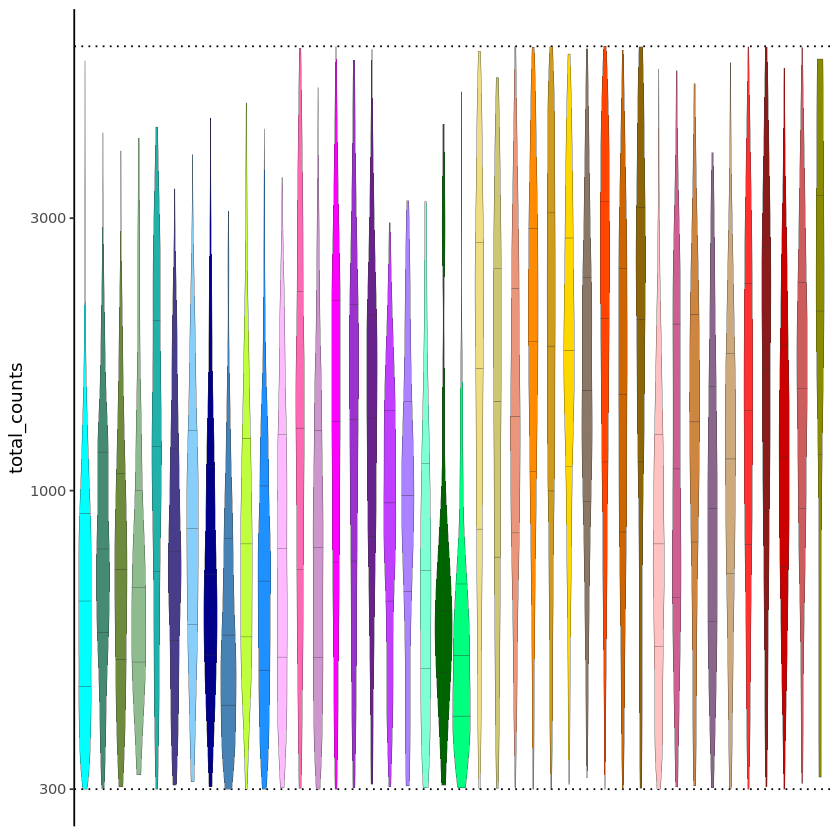

In [59]:
mat@cell_metadata[names(mc@mc[mc@annots[mc@mc] %in% cell_order]),] %>%
    mutate(annot = factor(mc@annots[metacell + 1], levels=cell_order)) %>%
    ggplot(aes(x=annot, fill=annot, y=total_counts)) +
    geom_hline(yintercept = c(300, 6000), linetype='dotted') +
    geom_violin(show.legend = F, draw_quantiles = c(0.25, 0.5, 0.75), width=1, linewidth=0.1) +
    scale_y_log10() +
    scale_fill_manual(values = c_vec) +
    theme(axis.title.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank(),
          axis.line.x = element_blank())
ggsave(filename = "final_figs/supp1/counts_per_pop.png", dpi=1200, width=110, height=55, units='mm')

# Figure 2

In [290]:
if(!dir.exists("final_figs/fig2")) dir.create("final_figs/fig2/")

In [291]:
anova_df = sapply(cell_order, function(pop){
    aov_res = aov(fraction ~ Age + condition, data = replicate_df[replicate_df$annotation == pop,])
    pval_df = TukeyHSD(aov_res, which = "Age")$Age %>% as.data.frame %>% select('p adj')
    pval_df['Age', 'p adj'] = summary(aov_res)[[1]]['Age',"Pr(>F)"]
    pval_df['condition', 'p adj'] = summary(aov_res)[[1]]['condition',"Pr(>F)"]
    return(as.matrix(pval_df))
}) %>% t %>% as.data.frame

In [292]:
colnames(anova_df) = c("3w-10d", "6w-10d", "8w-10d", "10w-10d", "12w-10d", "6w-3w", "8w-3w", "10w-3w", "12w-3w", "8w-6w", 
                       "10w-6w", "12w-6w", "10w-8w", "12w-8w", "12w-10w", "Age", "condition")

In [293]:
anova_df = anova_df[c("Age", "condition", "3w-10d", "6w-10d", "8w-10d", "10w-10d", "12w-10d", "6w-3w", "8w-3w", "10w-3w", 
                      "12w-3w", "8w-6w", "10w-6w", "12w-6w", "10w-8w", "12w-8w", "12w-10w")]

In [294]:
corr_anova_df = mutate_all(anova_df, function(x){p.adjust(x, method='fdr')})

In [295]:
write.csv(corr_anova_df, "final_figs/fig2/anova_table.csv")

In [296]:
replicate_df$Stage = factor(ifelse(replicate_df$Age %in% c('10d', '3w'), 'Prepuberty', 'Postpuberty'), 
                            levels=c('Prepuberty', 'Postpuberty'))

In [297]:
developmental_diff = sapply(cell_order, function(pop){
    test_params = wilcox.test(fraction ~ Stage, 
                              data = replicate_df, 
                              subset = replicate_df$annotation == pop, 
                              alternative = 'greater', exact = T, paired=F)
    return(test_params$p.value)
})

Warning message in wilcox.test.default(x = c(0.0690789473684211, 0.0568807339449541, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.0230263157894737, 0.0128440366972477, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.00657894736842105, 0, 0, 0, 0.00437956204379562, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0, 0, 0, 0, 0.00145985401459854, 0, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.00657894736842105, 0, 0.00555555555555556, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.00986842105263158, 0.0073394495412844, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.00328947368421053, 0.0073394495412844, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.00986842105263158, 0.0275229357798165, :
“c

In [298]:
p.adjust(developmental_diff, method = 'fdr') %>% sort %>% as.data.frame %>% write_csv("final_figs/fig2/pvals_development.csv")

In [299]:
cancer_diff = sapply(cell_order, function(pop){
    test_params = wilcox.test(fraction ~ condition, 
                              data = replicate_df, 
                              subset = replicate_df$annotation == pop & replicate_df$Stage == 'Postpuberty', 
                              alternative = 'greater', exact = T, paired=F)
    return(test_params$p.value)
})

Warning message in wilcox.test.default(x = c(0.0331491712707182, 0.0201793721973094, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.00736648250460405, 0.0134529147982063, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.00552486187845304, 0.00672645739910314, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.0589318600368324, 0.047085201793722, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0, 0, 0, 0.00868055555555556, 0.00887573964497041, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.0110497237569061, 0, 0.0105708245243129, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.00184162062615101, 0, 0.00211416490486258, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(0.0202578268876611, 0.0089686098654708

In [300]:
p.adjust(cancer_diff, method = 'fdr') %>% sort %>% as.data.frame %>% write_csv("final_figs/fig2/pvals_cancer.csv")

In [301]:
sum_df = replicate_df %>%
    group_by(annotation, Age, condition, Cell_type) %>% 
    summarise(mean_fraction=mean(fraction), sum_count=sum(Count))

sum_df$annotation = factor(sum_df$annotation, levels=cell_order)
sum_df$condition = factor(sum_df$condition, levels=cond_order)
sum_df$Age = factor(sum_df$Age, levels=age_order)

`summarise()` has grouped output by 'annotation', 'Age', 'condition'. You can
override using the `.groups` argument.


In [302]:
if(!dir.exists("final_figs/fig2/kinetic_bargraphs")) dir.create("final_figs/fig2/kinetic_bargraphs/")

for (cell_type in FACS_filters){
    plot_df = sum_df[sum_df$Cell_type == cell_type & sum_df$annotation %in% unlist(cell_type_annots[cell_type]),]
    p = ggplot(plot_df, aes(y=mean_fraction, x=1, fill=annotation)) + 
            geom_bar(position="fill", stat="identity", orientation = "x") +
            scale_fill_manual(values = group.colors[names(group.colors) %in% plot_df$annotation]) +
            facet_grid(condition ~ Age, switch = "both") +
            theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.y = element_blank(),
                  legend.box.margin = margin(c(0,0,0,5)),
                  legend.title = element_text(size=12),   
                  strip.background = element_rect(linetype="blank"),
                  axis.text.y = element_blank(), axis.text.x = element_blank(), axis.title.x = element_blank(),
                  axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
                  axis.line.x = element_blank(), axis.line.y = element_blank())
    l = get_legend(p)
    p = plot_grid(p + theme(legend.position="none"))
    
    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_", str_replace(cell_type, "\\+", ""), ".png"), plot = p, 
           width = 4, height = 6, dpi = 1200)
    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_", str_replace(cell_type, "\\+", ""), "_legend.png"), plot=l, 
           dpi = 1200)
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [303]:
if(!dir.exists("final_figs/fig2/fraction_linegraphs")) dir.create("final_figs/fig2/fraction_linegraphs/")
    

for (annot in cell_order){
    plot_df = sum_df[sum_df$annotation == annot,c("Age", "condition", "mean_fraction")]
    p = ggplot(plot_df, aes(x=Age, y=mean_fraction, col=condition)) +
        geom_boxplot(data=replicate_df[replicate_df$annotation == annot,], 
                   aes(y=fraction), size=1, show.legend = F, width=0.2,
                   position = position_dodge(width = 0.25)) +
        geom_line(aes(group=condition), size=1) +
        scale_color_manual(values = brightness(group.colors[annot], c(0.5, 1.5))) +
        labs(title=paste(annot, "fraction")) +
        theme(strip.text = element_text(size=12), plot.title = element_text(size=12, hjust=0.5),
              legend.text = element_blank(), legend.title = element_blank(), 
              legend.position = 'right',
              axis.title.y = element_text(size=12), axis.title.x =element_text(size=12),
              axis.text.y = element_text(size=12), axis.text.x = element_text(size=12, angle = 90, vjust = 0.5))

    ggsave(paste0("final_figs/fig2/fraction_linegraphs/fraction_", annot, "_box.png"), plot=p, units = 'mm',
           height=150, width=150, dpi = 1200)
}

In [304]:
for (pop_name in names(pop_orders)){
    plot_df = sum_df[sum_df$annotation %in% unlist(pop_orders[pop_name]),]
    p = ggplot(plot_df, aes(y=mean_fraction, x=1, fill=annotation)) + 
            geom_bar(position="fill", stat="identity", orientation = "x") +
            scale_fill_manual(values = group.colors[names(group.colors) %in% plot_df$annotation]) +
            facet_grid(condition ~ Age, switch = "both") +
            theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.y = element_blank(),
                  legend.box.margin = margin(c(0,0,0,5)),
                  legend.title = element_text(size=12),   
                  strip.background = element_rect(linetype="blank"),
                  axis.text.y = element_blank(), axis.text.x = element_blank(), axis.title.x = element_blank(),
                  axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
                  axis.line.x = element_blank(), axis.line.y = element_blank())

    l = get_legend(p)
    p = plot_grid(p + theme(legend.position="none"))

    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_", pop_name, ".png"), plot = p, width = 4, height = 6, 
           dpi = 1200)
    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_", pop_name, "_legend.png"), plot = l, width=4, height=6)
}

In [305]:
sum_df$broad_annotation = ifelse(sum_df$annotation %in% unique(annot_df$label)[fibroblast_order], "Fibroblast populations",
                                 ifelse(sum_df$annotation %in% unique(annot_df$label)[myeloid_order], "Myeloid populations",
                                 ifelse(sum_df$annotation %in% unique(annot_df$label)[lymphoid_order], "Lymphoid populations",
                                 ifelse(sum_df$annotation %in% unique(annot_df$label)[epithelial_order], "Epithelial populations",
                                 "Stromal populations"))))

broad_df = sum_df %>% 
    group_by(broad_annotation, Age, condition, Cell_type) %>% 
    summarise(total_frac=sum(mean_fraction))

broad_df$condition = factor(broad_df$condition, levels=cond_order)
broad_df$Age = factor(broad_df$Age, levels=age_order)

broad_order = c("Lymphoid populations", "Myeloid populations", "Epithelial populations", "Fibroblast populations", 
                "Stromal populations")
broad_df$broad_annotation = factor(broad_df$broad_annotation, levels=broad_order)
broad.colors = c("cyan3", "darkgreen", "darkgoldenrod1", "brown1", "tan")
names(broad.colors) = broad_order

`summarise()` has grouped output by 'broad_annotation', 'Age', 'condition'. You
can override using the `.groups` argument.


In [306]:
for (cell_type in unique(broad_df$Cell_type)){
    plot_df = broad_df[broad_df$Cell_type == cell_type,]
    if (cell_type == "CD45+"){plot_df = plot_df[plot_df$broad_annotation != "Epithelial populations",]}
    p = ggplot(plot_df, aes(y=total_frac, x=1, fill=broad_annotation)) + 
            geom_bar(position="fill", stat="identity", orientation = "x") +
            scale_fill_manual(values = broad.colors[names(broad.colors) %in% plot_df$broad_annotation]) +
            facet_grid(condition ~ Age, switch = "both") +
            theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.y = element_blank(),
                  legend.box.margin = margin(c(0,0,0,5)),
                  legend.title = element_text(size=12),   
                  strip.background = element_rect(linetype="blank"),
                  axis.text.y = element_blank(), axis.text.x = element_blank(), axis.title.x = element_blank(),
                  axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
                  axis.line.x = element_blank(), axis.line.y = element_blank())

    l = get_legend(p)
    p = plot_grid(p + theme(legend.position="none"))

    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_broad_", str_replace(cell_type, "\\+", ""), ".png"), 
           plot = p, width = 4, height = 6, dpi = 1200)
    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_broad_", str_replace(cell_type, "\\+", ""), "_legend.png"), 
           plot = l, width = 4, height = 6, dpi = 1200)
}

#### Epithelial variations

In [307]:
epithelial_df = full_df[full_df$annotation %in% unique(annot_df$label)[epithelial_order],]

In [308]:
sum(epithelial_df$Age == '12w' & epithelial_df$condition == 'normal')

[1] 711

In [309]:
sum(epithelial_df$Age == '12w' & epithelial_df$condition == 'normal')

[1] 711

In [310]:
# Unified
epi_rep_df = group_by(epithelial_df, annotation, Age, condition, Replicate) %>% 
    summarise(Count=length(annotation)) %>% drop_na() %>% as.data.frame %>%
    tidyr::complete(annotation, Age, condition, Replicate, fill=list(Count=0))

epi_rep_df = epi_rep_df %>%
    group_by(Age, condition, Replicate) %>% 
    summarise(annotation=annotation, 
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count),
              Replicate = Replicate) %>% 
    filter(total > 20)

epi_rep_df$annotation = factor(epi_rep_df$annotation, levels=cell_order)
epi_rep_df$condition = factor(epi_rep_df$condition, levels=cond_order)
epi_rep_df$Age = factor(epi_rep_df$Age, levels=age_order)
epi_rep_df$Replicate = factor(epi_rep_df$Replicate, levels=1:5)

`summarise()` has grouped output by 'annotation', 'Age', 'condition'. You can
override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'Replicate'. You can
override using the `.groups` argument.


In [311]:
epi_sum_df = epi_rep_df %>%
    group_by(annotation, Age, condition) %>% 
    summarise(mean_fraction=mean(fraction), sum_count=sum(Count))

epi_sum_df$annotation = factor(epi_sum_df$annotation, levels=cell_order)
epi_sum_df$condition = factor(epi_sum_df$condition, levels=cond_order)
epi_sum_df$Age = factor(epi_sum_df$Age, levels=age_order)

`summarise()` has grouped output by 'annotation', 'Age'. You can override using
the `.groups` argument.


In [312]:
p = ggplot(epi_sum_df, aes(y=mean_fraction, x=1, fill=annotation)) + 
        geom_bar(position="fill", stat="identity", orientation = "x") +
        scale_fill_manual(values = group.colors[names(group.colors) %in% epi_sum_df$annotation]) +
        facet_grid(condition ~ Age, switch = "both") +
        theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.y = element_blank(),
              legend.box.margin = margin(c(0,0,0,5)),
              legend.title = element_text(size=12),   
              strip.background = element_rect(linetype="blank"),
              axis.text.y = element_blank(), axis.text.x = element_blank(), axis.title.x = element_blank(),
              axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
              axis.line.x = element_blank(), axis.line.y = element_blank())
l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave(paste0("final_figs/fig2/epithelial_variations/unified/kinetic_bars_epithelial_unified.png"), plot = p, 
       width = 4, height = 6, dpi = 1200)

In [313]:
    plot_df = sum_df[sum_df$annotation == annot,c("Age", "condition", "mean_fraction")]
    p = ggplot(plot_df, aes(x=Age, y=mean_fraction, col=condition)) +
        geom_boxplot(data=replicate_df[replicate_df$annotation == annot,], 
                   aes(y=fraction), size=1, show.legend = F, width=0.2,
                   position = position_dodge(width = 0.25)) +
        geom_line(aes(group=condition), size=1) +
        scale_color_manual(values = brightness(group.colors[annot], c(0.5, 1.5))) +
        labs(title=paste(annot, "fraction")) +
        theme(strip.text = element_text(size=12), plot.title = element_text(size=12, hjust=0.5),
              legend.text = element_blank(), legend.title = element_blank(), 
              legend.position = 'right',
              axis.title.y = element_text(size=12), axis.title.x =element_text(size=12),
              axis.text.y = element_text(size=12), axis.text.x = element_text(size=12, angle = 90, vjust = 0.5))

    ggsave(paste0("final_figs/fig2/fraction_linegraphs/fraction_", annot, "_box.png"), plot=p, units = 'mm',
           height=150, width=150, dpi = 1200)


In [314]:
for (annot in unique(annot_df$label)[epithelial_order]){
    plot_df = epi_sum_df[epi_sum_df$annotation == annot,c("Age", "condition", "mean_fraction")]
    p = ggplot(plot_df, aes(x=Age, y=mean_fraction, col=condition)) +
        geom_boxplot(data=epi_rep_df[epi_rep_df$annotation == annot,], 
                   aes(y=fraction), size=1, show.legend = F, width=0.2,
                   position = position_dodge(width = 0.25)) +
        geom_line(aes(group=condition), size=1) +
        scale_color_manual(values = brightness(group.colors[annot], c(0.5, 1.5))) +
        labs(title=paste(annot, "fraction")) +
        theme(strip.text = element_text(size=12), plot.title = element_text(size=12, hjust=0.5),
              legend.text = element_blank(), legend.title = element_blank(), 
              legend.position = 'right',
              axis.title.y = element_text(size=12), axis.title.x =element_text(size=12),
              axis.text.y = element_text(size=12), axis.text.x = element_text(size=12, angle = 90, vjust = 0.5))

    ggsave(paste0("final_figs/fig2/epithelial_variations/unified/fraction_", annot, "_box.png"), plot=p, units = 'mm',
           height=150, width=150, dpi = 1200)
}

In [96]:
epithelial_df = full_df[full_df$annotation %in% unique(annot_df$label)[epithelial_order] & full_df$Cell_type == "CD45-",]

In [97]:
# CD45-
epi_rep_df = group_by(epithelial_df, annotation, Age, condition, Replicate) %>% 
    summarise(Count=length(annotation)) %>% drop_na() %>% as.data.frame %>%
    tidyr::complete(annotation, Age, condition, Replicate, fill=list(Count=0))

epi_rep_df = epi_rep_df %>%
    group_by(Age, condition, Replicate) %>% 
    summarise(annotation=annotation, 
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count),
              Replicate = Replicate) %>% 
    filter(total > 50)

epi_rep_df$annotation = factor(epi_rep_df$annotation, levels=cell_order)
epi_rep_df$condition = factor(epi_rep_df$condition, levels=cond_order)
epi_rep_df$Age = factor(epi_rep_df$Age, levels=age_order)
epi_rep_df$Replicate = factor(epi_rep_df$Replicate, levels=1:5)

`summarise()` has grouped output by 'annotation', 'Age', 'condition'. You can
override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'Replicate'. You can
override using the `.groups` argument.


In [98]:
epi_sum_df = epi_rep_df %>%
    group_by(annotation, Age, condition) %>% 
    summarise(mean_fraction=mean(fraction))

epi_sum_df$annotation = factor(epi_sum_df$annotation, levels=cell_order)
epi_sum_df$condition = factor(epi_sum_df$condition, levels=cond_order)
epi_sum_df$Age = factor(epi_sum_df$Age, levels=age_order)

`summarise()` has grouped output by 'annotation', 'Age'. You can override using
the `.groups` argument.


In [99]:
p = ggplot(epi_sum_df, aes(y=mean_fraction, x=1, fill=annotation)) + 
        geom_bar(position="fill", stat="identity", orientation = "x") +
        scale_fill_manual(values = group.colors[names(group.colors) %in% epi_sum_df$annotation]) +
        facet_grid(condition ~ Age, switch = "both") +
        theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.y = element_blank(),
              legend.box.margin = margin(c(0,0,0,5)),
              legend.title = element_text(size=12),   
              strip.background = element_rect(linetype="blank"),
              axis.text.y = element_blank(), axis.text.x = element_blank(), axis.title.x = element_blank(),
              axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
              axis.line.x = element_blank(), axis.line.y = element_blank())
l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave(paste0("final_figs/fig2/epithelial_variations/cd45negative/kinetic_bars_epithelial_unified.png"), plot = p, 
       width = 4, height = 6, dpi = 1200)

In [100]:
for (annot in unique(annot_df$label)[epithelial_order]){
    plot_df = epi_sum_df[epi_sum_df$annotation == annot,c("Age", "condition", "mean_fraction")]
    p = ggplot(plot_df, aes(x=Age, y=mean_fraction, col=condition)) +
        geom_boxplot(data=epi_rep_df[epi_rep_df$annotation == annot,], 
                   aes(y=fraction), size=0.1, show.legend = F, width=0.2,
                   position = position_dodge(width = 0.25)) +
        geom_line(aes(group=condition), size=0.5) +
        scale_color_manual(values = brightness(group.colors[annot], c(0.5, 1.5))) +
        labs(title=paste(annot, "fraction")) +
        theme(strip.text = element_text(size=12), plot.title = element_text(size=12, hjust=0.5),
              legend.text = element_blank(), legend.title = element_blank(), 
              legend.position = 'right',
              axis.title.y = element_text(size=12), axis.title.x =element_text(size=12),
              axis.text.y = element_text(size=12), axis.text.x = element_text(size=12, angle = 90, vjust = 0.5))

    ggsave(paste0("final_figs/fig2/epithelial_variations/cd45negative/fraction_", annot, "_box.png"), plot=p, units = 'mm',
           height=150, width=150, dpi = 1200)
}

#### heatmap

In [228]:
sum_df$age_condition = factor(paste(sum_df$condition, sum_df$Age, sep="_"), levels = age_condition_order)

In [229]:
wide_df = dcast(sum_df, annotation ~ age_condition, value.var = "mean_fraction") %>% 
    column_to_rownames("annotation") %>% t %>% scale %>% t %>% as.data.frame

In [230]:
wide_df$TumorLogFoldEnrichment = proportion_df[rownames(wide_df),'log_ratio']

In [231]:
annotation_col = data.frame(condition=sapply(colnames(wide_df), function(x){unlist(str_split(x, "_"))[1]}))

In [232]:
dist_mat <- dist(wide_df, method = 'euclidean')

In [233]:
hclust_avg <- hclust(dist_mat, method = 'complete')

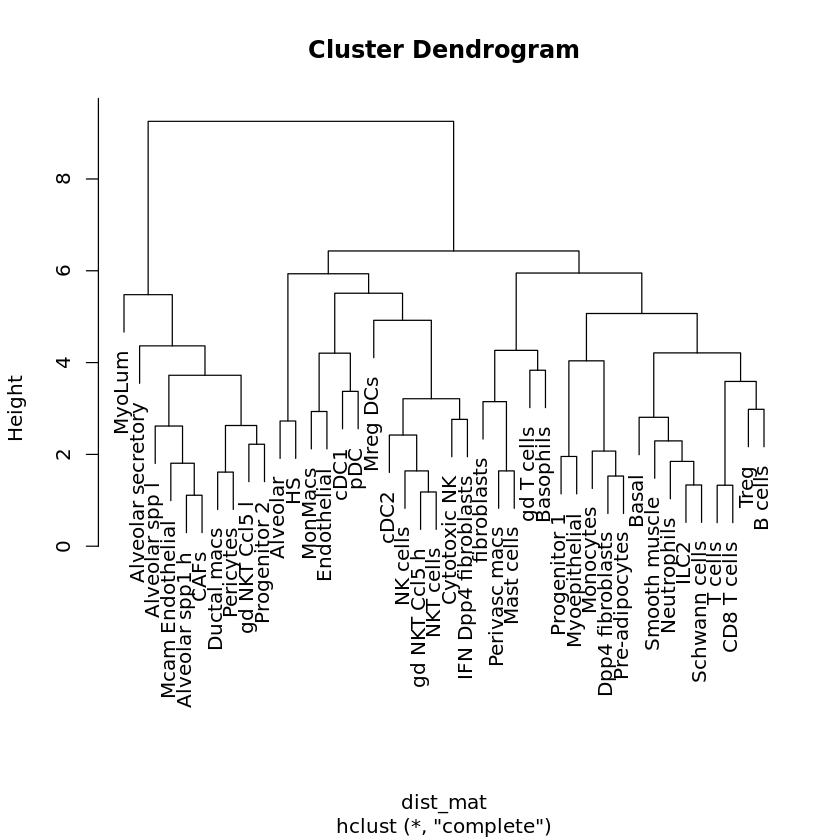

In [234]:
plot(hclust_avg)

In [235]:
cat(rownames(wide_df)[hclust_avg$order], sep='", "')

MyoLum", "Alveolar secretory", "Alveolar spp l", "Mcam Endothelial", "Alveolar spp1 h", "CAFs", "Ductal macs", "Pericytes", "gd NKT Ccl5 l", "Progenitor 2", "Alveolar", "HS", "MonMacs", "Endothelial", "cDC1", "pDC", "Mreg DCs", "cDC2", "NK cells", "gd NKT Ccl5 h", "NKT cells", "Cytotoxic NK", "IFN Dpp4 fibroblasts", "fibroblasts", "Perivasc macs", "Mast cells", "gd T cells", "Basophils", "Progenitor 1", "Myoepithelial", "Monocytes", "Dpp4 fibroblasts", "Pre-adipocytes", "Basal", "Smooth muscle", "Neutrophils", "ILC2", "Schwann cells", "T cells", "CD8 T cells", "Treg", "B cells

In [236]:
manual_order = rev(rownames(wide_df)[hclust_avg$order])

manual_order = c("Basal", "Myoblasts", "Lyve1 Perivasc macs", "Basophils", "ILC2", "Schwann cells", "Treg", "Dpp4 fibroblasts", 
                 "Adipocytes", "Monocytes", "Mast cells", "Luminal progenitor", "Alveolar progenitor", "Fibroblasts", "pDC", 
                 "Myoepithelial", "Luminal HS", "Perivasc macs", "cDC2", "cDC1", "IFN Dpp4 fibroblasts", "MonMacs", "B cells", 
                 "T cells", "CD8 T cells", "NK cells", "Cytotoxic NK", "gd T cells", "NKT cells", "gd NKT cells", 
                 "Smooth muscle", "Endothelial", "Pericytes", "Mreg DCs", "Neutrophils", "Tumor Spp1 low", "Ductal macs", 
                 "CAFs", "Tumor Spp1 high", "Alveolar secretory", "Myoepithelial-luminal")

In [237]:
cat(manual_order, sep="\n")

B cells
Treg
CD8 T cells
T cells
Schwann cells
ILC2
Neutrophils
Smooth muscle
Basal
Pre-adipocytes
Dpp4 fibroblasts
Monocytes
Myoepithelial
Progenitor 1
Basophils
gd T cells
Mast cells
Perivasc macs
fibroblasts
IFN Dpp4 fibroblasts
Cytotoxic NK
NKT cells
gd NKT Ccl5 h
NK cells
cDC2
Mreg DCs
pDC
cDC1
Endothelial
MonMacs
HS
Alveolar
Progenitor 2
gd NKT Ccl5 l
Pericytes
Ductal macs
CAFs
Alveolar spp1 h
Mcam Endothelial
Alveolar spp l
Alveolar secretory
MyoLum


In [238]:
all(rownames(wide_df) %in% manual_order)

[1] TRUE

In [239]:
all(rownames(wide_df)[hclust_avg$order] %in% manual_order)

[1] TRUE

In [8]:
c("MyoLum", "Alveolar secretory", "Alveolar spp l", "Mcam Endothelial", "Alveolar spp1 h", "CAFs", "Ductal macs", "Pericytes", "gd NKT Ccl5 l", "Progenitor 2") %>% length

[1] 10

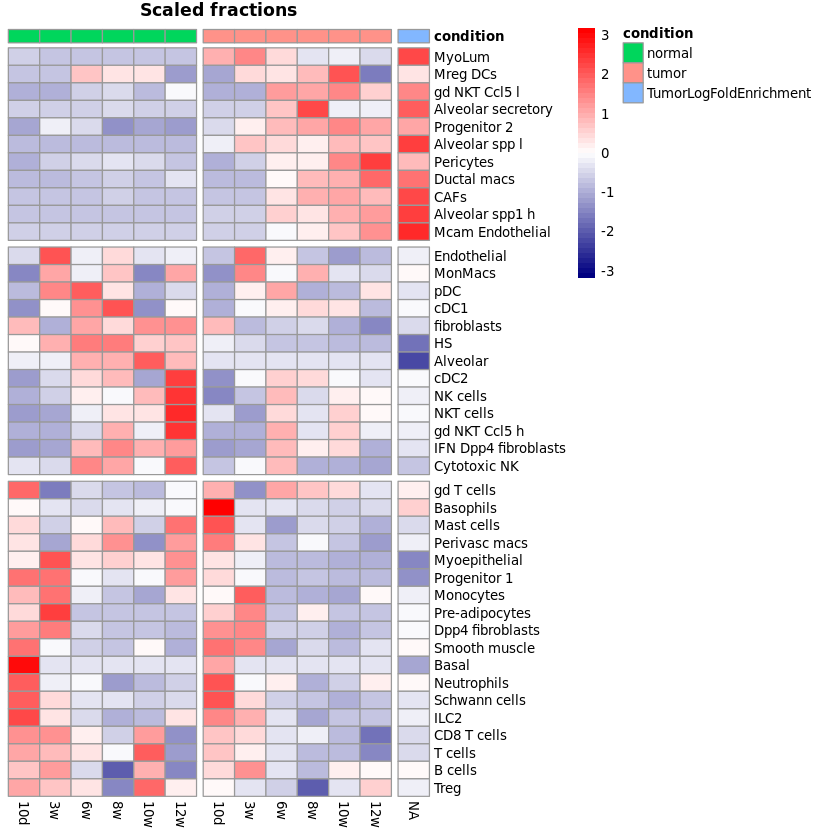

In [276]:
p = pheatmap(as.matrix(wide_df[manual_order,]), main="Scaled fractions", scale = 'row', treeheight_row = 0,
         fontsize = 8, #cellwidth = 40, cellheight = 20, 
         annotation_col = annotation_col, cluster_cols = F, cluster_rows = T, cutree_rows=3, gaps_col = c(6, 12),
         labels_col = sapply(colnames(wide_df), function(x){unlist(str_split(x, "_"))[2]}),
         color=colorRampPalette(c("navy", "white", "red"))(50))

In [40]:
png("final_figs/fig2/fraction_heatmap.png", width = 18, height = 12, units = 'cm', res = 1200)
p
dev.off()

ERROR: Error in eval(expr, envir, enclos): object 'p' not found


In [92]:
for (facs_filter in unique(facs_data$FACs.Filter)){
    ggplot(facs_data[facs_data$FACs.Filter == facs_filter,], aes(x=Age, y=Percentage, color=Condition)) +
        stat_summary(aes(group=Condition), fun=mean, geom="line") +
        geom_jitter(position = position_jitterdodge(jitter.width = 0.3, dodge.width = 0.5), show.legend = F) +
        labs(title = paste0('FACs percentage - ', facs_filter))
    ggsave(paste0("final_figs/supp1/facs/", str_replace(facs_filter, "/", "_"), ".png"))
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Saving 6.67 x 6.67 in image


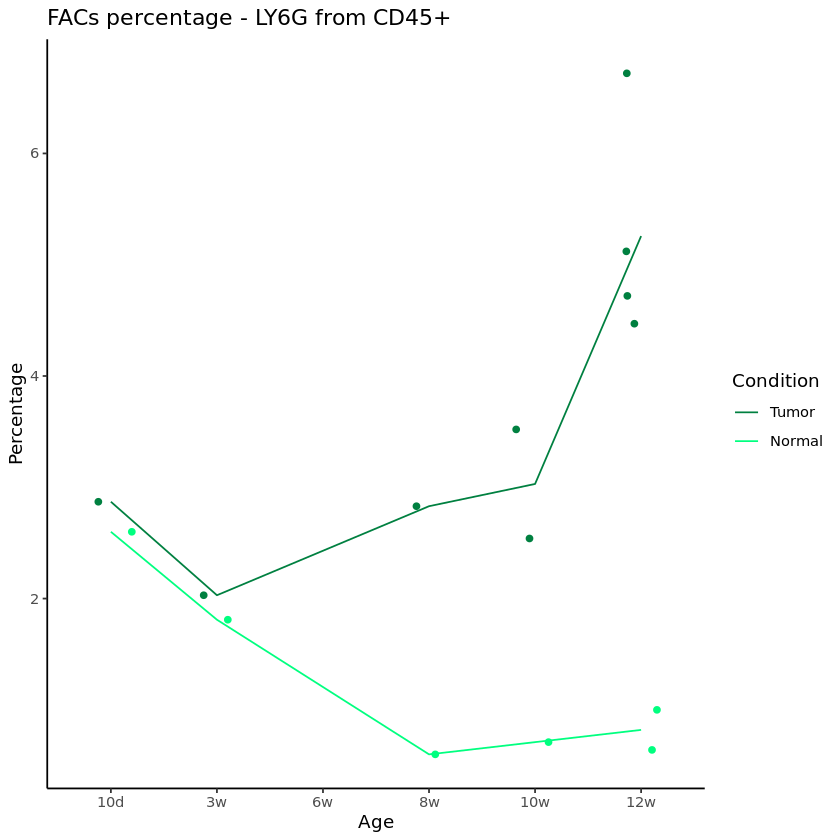

In [93]:
ggplot(facs_data[facs_data$FACs.Filter == 'LY6G',], aes(x=Age, y=Percentage, color=Condition)) +
    stat_summary(aes(group=Condition), fun=mean, geom="line") +
    geom_jitter(position = position_jitterdodge(jitter.width = 0.3, dodge.width = 0.5), show.legend = F) +
    scale_color_manual(values = brightness(group.colors['Neutrophils'], c(0.5, 1.5))) +
    scale_x_discrete(breaks = age_order, drop=F) +
    labs(title = 'FACs percentage - LY6G from CD45+')
ggsave("final_figs/supp1/facs/ly6g_from_cd45.png", dpi=1200)

Saving 6.67 x 6.67 in image


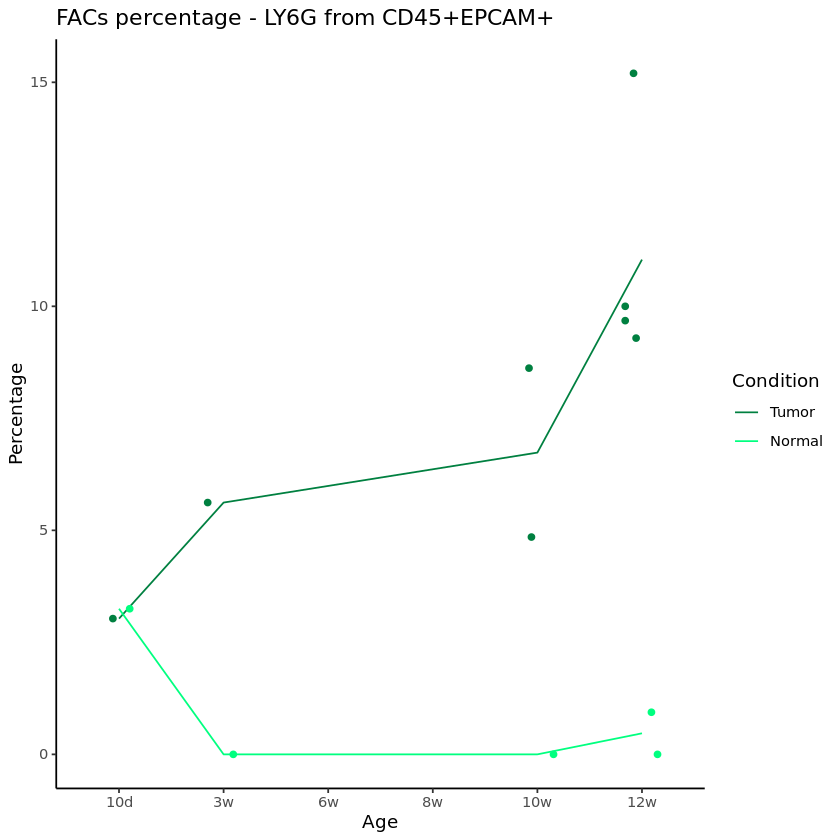

In [94]:
ggplot(facs_data[facs_data$FACs.Filter == 'LY6G/EPCAM' & facs_data$Age != '8w',], aes(x=Age, y=Percentage, color=Condition)) +
    stat_summary(aes(group=Condition), fun=mean, geom="line") +
    geom_jitter(position = position_jitterdodge(jitter.width = 0.3, dodge.width = 0.5), show.legend = F) +
    scale_x_discrete(breaks = age_order, drop=F) +
    scale_color_manual(values = brightness(group.colors['Neutrophils'], c(0.5, 1.5))) +
    labs(title = 'FACs percentage - LY6G from CD45+EPCAM+')
ggsave("final_figs/supp1/facs/ly6g_from_cd45epcam.png", dpi=1200)

Saving 6.67 x 6.67 in image


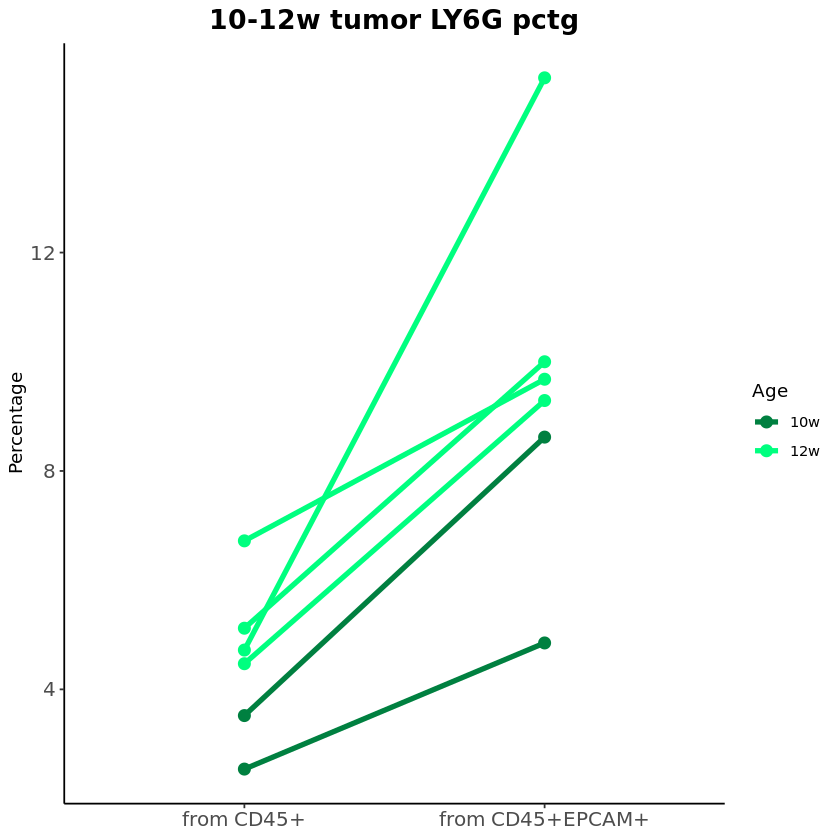

In [136]:
facs_data[facs_data$FACs.Filter %in% c('LY6G', 'LY6G/EPCAM') & facs_data$Age %in% c('10w', '12w') & 
          facs_data$Condition == 'Tumor',] %>%
    ggplot(aes(x=FACs.Filter, y=Percentage, color=Age, group=batch_name)) +
        geom_point(size=3) +
        geom_line(size=1.5) +
        labs(title = '10-12w tumor LY6G pctg') +
        scale_color_manual(values = brightness(group.colors['Neutrophils'], c(0.5, 1.5))) +
        scale_x_discrete(labels=c('from CD45+', 'from CD45+EPCAM+')) +
        theme(axis.title.x=element_blank(), axis.text = element_text(size=12),
              plot.title = element_text(hjust=0.5, size=16, face = 'bold'))
ggsave('final_figs/fig3/ly6g_singlet_vs_pics.png', dpi=1200)

In [116]:
test_df = facs_data[facs_data$FACs.Filter %in% c('LY6G', 'LY6G/EPCAM') & facs_data$Age %in% c('10w', '12w') & 
          facs_data$Condition == 'Tumor',] %>% 
    dcast(FACs.Filter ~ batch_name, value.var = 'Percentage') %>% 
    column_to_rownames('FACs.Filter') %>% t %>% as.data.frame

In [131]:
wilcox.test(test_df$LY6G, test_df$`LY6G/EPCAM`, paired = T)


	Wilcoxon signed rank exact test

data:  test_df$LY6G and test_df$`LY6G/EPCAM`
V = 0, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0
